In [1]:
# Importa el archivo .py
import FeatureEngeneniering

# Llama a la función para obtener el DataFrame
df_completo = FeatureEngeneniering.df



c:\Users\jpcan\OneDrive\Documentos\Andes Universidad\Proyecto de grado 1\Tesis final\Limpiezadatosenpy.py:4: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/BaseDatos/registro_atencion_unidad_observacion_urgencia.csv")


  NumeroFactura CodigoPrestador FechaIngreso HoraIngreso        CausaExterna  \
0        288306     50010217203   2019-12-26       23:38  Enfermedad general   
1    4129237242     50010425930   2019-12-21       05:17  Enfermedad general   
2    4129237242     50010425930   2019-12-23       07:29  Enfermedad general   
4    4129237242     50010425930   2019-12-29       09:16  Enfermedad general   
6      CL375831     50010909923   2019-12-16       07:31  Enfermedad general   

  CodigoDiagnosticoPrincipal CodigoDiagnosticoRelacionado_uno  \
0                       A059                             I48X   
1                       R509                             \"\"   
2                       N23X                             \"\"   
4                       C698                             \"\"   
6                       S019                             S400   

  CodigoDiagnosticoRelacionado_dos CodigoDiagnosticoRelacionado_tres  \
0                             \"\"                      

c:\Users\jpcan\OneDrive\Documentos\Andes Universidad\Proyecto de grado 1\Tesis final\Limpiezadatosenpy.py:363: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DescripcionDiagnosticoPrincipal'].replace({np.nan: "No tuvo", 'nan': "No tuvo", '\\"\\': "No tuvo"}, inplace=True)
c:\Users\jpcan\OneDrive\Documentos\Andes Universidad\Proyecto de grado 1\Tesis final\Limpiezadatosenpy.py:364: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior wi

  CodigoPrestador   RangoDias  Hospitaloccupancy
0     50010115001  2019-01-01                  2
1     50010115001  2019-01-02                  3
2     50010115001  2019-01-04                  2
3     50010115001  2019-01-05                  2
4     50010115001  2019-01-06                  1


# Hay que ejecutar este para hacer algunos analisis del impacto de las variables en catboost

In [ ]:

# Importa el archivo .py
import Limpiezadatosenpy

# Llama a la función para obtener el DataFrame
df = Limpiezadatosenpy.df
import pandas as pd
# Leer el archivo CSV y convertirlo en un DataFrame
ocupacion_diaria = pd.read_csv("C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Tesis final/hospital_data_with_occupancy.csv")
ocupacion_diaria['CodigoPrestador'] = ocupacion_diaria['CodigoPrestador'].astype(str)
# Convertir 'RangoDias' a solo fechas, eliminando las horas
ocupacion_diaria['RangoDias'] = pd.to_datetime(ocupacion_diaria['RangoDias']).dt.date

# Agrupar por CodigoPrestador y RangoDias, y sumar la columna Hospitaloccupancy
ocupacion_diaria_agrupada = ocupacion_diaria.groupby(['CodigoPrestador', 'RangoDias'], as_index=False)['Hospitaloccupancy'].sum()

# Mostrar el DataFrame agrupado y consolidado
print(ocupacion_diaria_agrupada.head())

# Realizar la unión entre ambos DataFrames usando 'left' para mantener todas las filas de df
df = df.merge(ocupacion_diaria, how='left', left_on=['CodigoPrestador', 'FechaIngreso'], right_on=['CodigoPrestador', 'RangoDias'])

  CodigoPrestador   RangoDias  Hospitaloccupancy
0     50010115001  2019-01-01                  2
1     50010115001  2019-01-02                  3
2     50010115001  2019-01-04                  2
3     50010115001  2019-01-05                  2
4     50010115001  2019-01-06                  1


# Ver cuantas variables dummies quedarin con One hot encoding

In [11]:

categorical_columns = df_completo.select_dtypes(include=['object']).columns

# Contar los valores únicos en cada columna categórica
unique_values = df_completo[categorical_columns].nunique()

# Mostrar los resultados
print("Valores únicos por variable categórica:")
print(unique_values)

# Si deseas obtener el total de dimensiones después de crear variables dummies
total_dimensiones = unique_values.sum()
print(f"Total de dimensiones después de crear variables dummies: {total_dimensiones}")

Valores únicos por variable categórica:
CausaExterna                               15
TipoUsuario                                 7
Sexo                                        2
ZonaResidencia                              2
NombrePrestadorSede                        55
nombreEAPB                                168
NombreDepto                                33
NombreMunicipio                           604
DescripcionDiagnosticoPrincipal           245
DescripcionDiagnosticoRelacionado_uno     242
DescripcionDiagnosticoRelacionado_dos     241
DescripcionDiagnosticoRelacionado_tres    241
dtype: int64
Total de dimensiones después de crear variables dummies: 1855


# Partición de los datos

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import numpy as np



# Estas fueron las columnas que se dejaron al final para Catboost, para los otros modelos tocar eliminar diferentes variables ver tabla 1.
X = df_completo.drop(columns=['TiempoenUrgencias', 'DescripcionDiagnosticoRelacionado_tres', 'Sexo', "ZonaResidencia", "NombreMunicipio", "NombreDepto","CausaExterna", "nombreEAPB","Edad", "TipoUsuario"])  # 'TiempoenUrgencias' es tu columna objetivo
y = df_completo['TiempoenUrgencias']



# Configurar 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# XGBoost

In [46]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import joblib

# Ajustar los hiperparámetros para reducir el sobreajuste
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.005,         # Ajustar la tasa de aprendizaje
    'max_depth': 2,                 # Reducir la profundidad del árbol
    'lambda': 20,                   # Aumentar la regularización L2
    'alpha': 20,                    # Aumentar la regularización L1
    'subsample': 0.4,               # Reducir aún más el porcentaje de muestras utilizadas en cada árbol
    'colsample_bytree': 0.4,        # Reducir aún más el porcentaje de características utilizadas
    'min_child_weight': 30,         # Aumentar el peso mínimo en las hojas
    'tree_method': 'hist',
    'eval_metric': 'mae'
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Usar 10-fold cross-validation


# Convertir las variables categóricas en tipo 'category'
# Convertir las variables categóricas en tipo 'category'
categorical_columns = [
    'CausaExterna',                     # 15 categorías
    'TipoUsuario',                      # 7 categorías
    'Sexo',                             # 2 categorías
    'ZonaResidencia',                   # 2 categorías
    'NombrePrestadorSede',              # 55 categorías
    'nombreEAPB',                       # 168 categorías
    'NombreDepto',                      # 33 categorías
    'NombreMunicipio',                  # 604 categorías
    'DescripcionDiagnosticoPrincipal',  # 245 categorías
    'DescripcionDiagnosticoRelacionado_uno',  # 242 categorías
    'DescripcionDiagnosticoRelacionado_dos',  # 241 categorías
    'DescripcionDiagnosticoRelacionado_tres'  # 241 categorías
]


# Crear una copia de X
X_combined = X.copy()

# Asegurarse de que las columnas categóricas estén en el tipo correcto
X_combined[categorical_columns] = X_combined[categorical_columns].astype('category')



train_mae_scores = []
val_mae_scores = []
best_val_mae = float('inf')
best_model = None

for fold, (train_index, val_index) in enumerate(kf.split(X_combined), 1):
    # Dividir los datos en entrenamiento y validación
    X_train, X_val = X_combined.iloc[train_index], X_combined.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Aplicar capping a la variable objetivo en los datos de entrenamiento
    y_train_clipped = np.clip(y_train, None, 100)  # Limitar los valores máximos en el conjunto de entrenamiento

    # Crear los DMatrix para XGBoost con enable_categorical=True
    dtrain = xgb.DMatrix(X_train, label=y_train_clipped, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

    # Entrenar el modelo con early stopping para evitar sobreajuste
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=2000,         # Aumentar el número de iteraciones
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,     # Early stopping más agresivo
        verbose_eval=False            # Evitar la impresión de resultados intermedios
    )

    # Predicciones en el conjunto de validación
    y_val_pred = model.predict(dval)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mae_scores.append(val_mae)

    # Predicciones en el conjunto de entrenamiento
    y_train_pred = model.predict(dtrain)
    train_mae = mean_absolute_error(y_train_clipped, y_train_pred)
    train_mae_scores.append(train_mae)

    # Guardar el mejor modelo basado en validación
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model

    # Imprimir el progreso de cada fold
    print(f"Fold {fold} - MAE en Entrenamiento: {train_mae:.4f}, MAE en Validación: {val_mae:.4f}")

# Promedio de MAE para entrenamiento y validación
mean_train_mae = np.mean(train_mae_scores)
mean_val_mae = np.mean(val_mae_scores)

print(f"MAE promedio en el conjunto de entrenamiento: {mean_train_mae:.4f}")
print(f"MAE promedio en el conjunto de validación: {mean_val_mae:.4f}")

# Guardar el mejor modelo entrenado en el conjunto de validación
model_save_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/best_xgboost_model.pkl"
joblib.dump(best_model, model_save_path)
print(f"El mejor modelo ha sido guardado en: {model_save_path}")






Fold 1 - MAE en Entrenamiento: 11.4811, MAE en Validación: 20.5142
Fold 2 - MAE en Entrenamiento: 11.4783, MAE en Validación: 20.7117
Fold 3 - MAE en Entrenamiento: 11.4812, MAE en Validación: 20.5119
Fold 4 - MAE en Entrenamiento: 11.4635, MAE en Validación: 20.4488
Fold 5 - MAE en Entrenamiento: 11.4810, MAE en Validación: 20.7108
MAE promedio en el conjunto de entrenamiento: 11.4770
MAE promedio en el conjunto de validación: 20.5795
El mejor modelo ha sido guardado en: C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/best_xgboost_model.pkl


# Impacto variables modelo XGBoost

                                   Feature  Importance
4                      NombrePrestadorSede      1148.0
7          DescripcionDiagnosticoPrincipal      1033.0
5                               nombreEAPB       842.0
11                       Hospitaloccupancy       829.0
9    DescripcionDiagnosticoRelacionado_dos       640.0
8    DescripcionDiagnosticoRelacionado_uno       613.0
1                              TipoUsuario       266.0
2                                     Edad       241.0
10  DescripcionDiagnosticoRelacionado_tres       190.0
0                             CausaExterna       118.0
6                          NombreMunicipio        68.0
3                                     Sexo        12.0


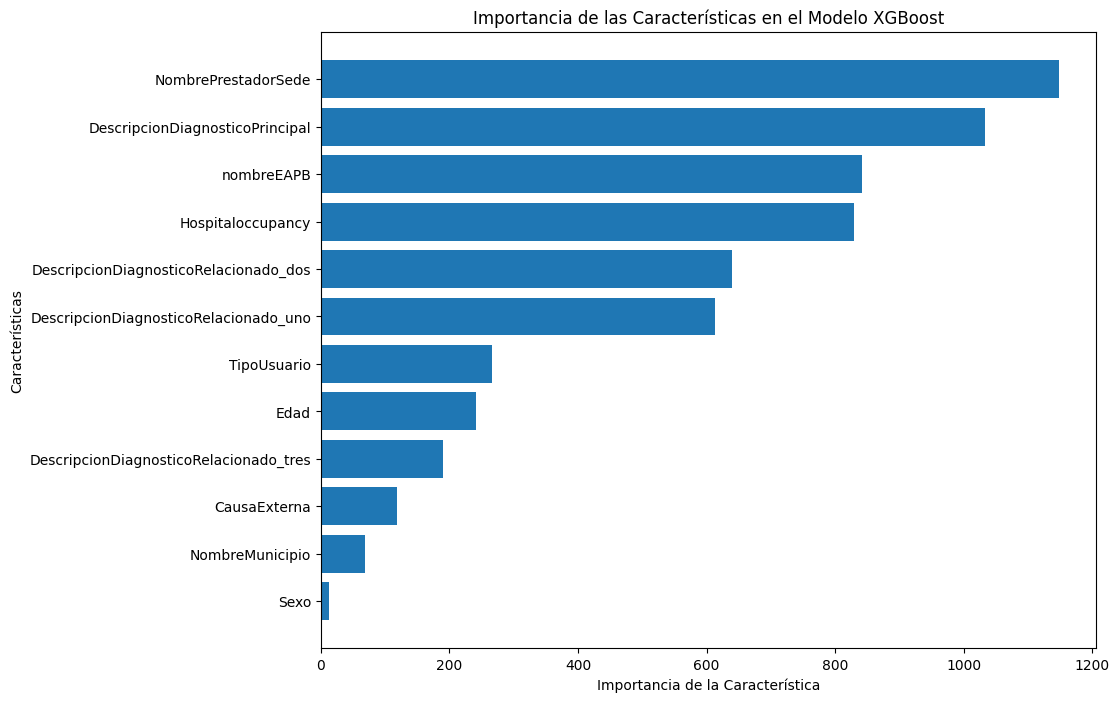

In [47]:
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Ruta del modelo guardado
model_save_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/best_xgboost_model.pkl"

# Cargar el modelo
model = joblib.load(model_save_path)

# Obtener la importancia de las características
feature_importances = model.get_score(importance_type='weight')

# Convertir la importancia en un DataFrame para mejor visualización
feature_importances_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Mostrar el DataFrame
print(feature_importances_df)

# Graficar la importancia de características
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel("Importancia de la Característica")
plt.ylabel("Características")
plt.title("Importancia de las Características en el Modelo XGBoost")
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén arriba
plt.show()


# CatBoost Implementation

Fold 1: MAE en Entrenamiento: 8.8739, MAE en Validación: 8.8866
Fold 2: MAE en Entrenamiento: 8.8874, MAE en Validación: 8.9475
Fold 3: MAE en Entrenamiento: 8.8703, MAE en Validación: 8.8853
Fold 4: MAE en Entrenamiento: 8.8606, MAE en Validación: 8.9339
Fold 5: MAE en Entrenamiento: 8.8845, MAE en Validación: 8.9211

MAE promedio en el conjunto de entrenamiento: 8.8753
MAE promedio en el conjunto de validación: 8.9149


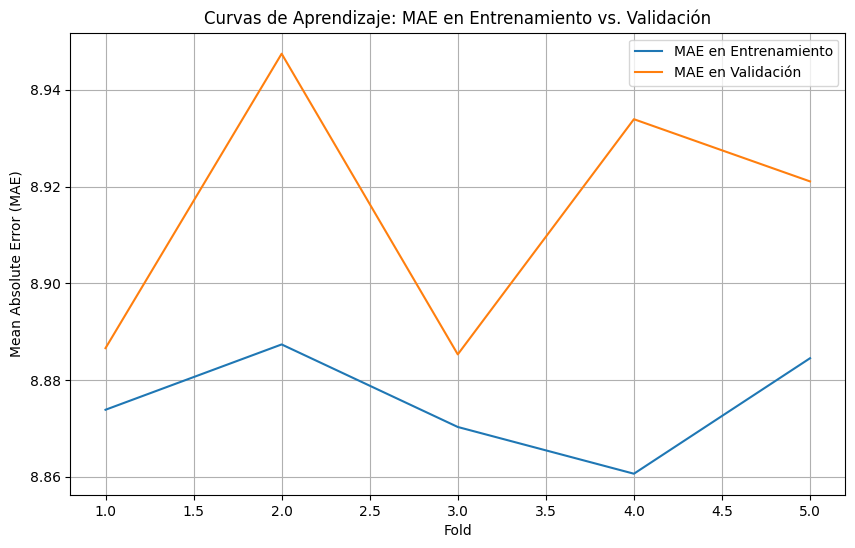

El mejor modelo se ha guardado en C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import joblib

# Definir los hiperparámetros actualizados
params = {
    'depth': 6, 
    'learning_rate': 0.05, 
    'iterations': 500,  # Aumentar las iteraciones
    'l2_leaf_reg': 10,  # Regularización L2 para reducir el overfitting
    'loss_function': 'MAE'  # Cambiar la función de pérdida a MAE
}

# Crear una instancia de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Identificar columnas categóricas (si no las tienes definidas manualmente)
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Función para aplicar capping (manejo de outliers) al percentil 95
def aplicar_capping(y, limite_percentil=95):
    limite_superior = np.percentile(y, limite_percentil)
    y_cap = np.where(y > limite_superior, limite_superior, y)
    return y_cap

def train_catboost_single(X, y):
    # Aplicar capping en la variable de respuesta para manejar outliers
    y = aplicar_capping(y)
    
    cv_mae_val = []
    cv_mae_train = []
    best_val_mae = float('inf')  # Inicializar con un valor muy alto para encontrar el mejor MAE
    best_model = None  # Inicializar el mejor modelo
    
    for fold, (train_index, val_index) in enumerate(kf.split(X), 1):  # Agregar un contador para el fold
        if isinstance(X, np.ndarray):
            X_train, X_val = X[train_index], X[val_index]
        else:
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        
        if isinstance(y, np.ndarray):
            y_train, y_val = y[train_index], y[val_index]
        else:
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Entrenar el modelo con CatBoost
        model = CatBoostRegressor(cat_features=categorical_columns, **params, verbose=0, early_stopping_rounds=50)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)

        # Predicciones en el conjunto de entrenamiento
        y_train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        cv_mae_train.append(train_mae)
        
        # Predicciones en el conjunto de validación
        y_val_pred = model.predict(X_val)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        cv_mae_val.append(val_mae)
        
        # Imprimir el MAE de cada fold
        print(f"Fold {fold}: MAE en Entrenamiento: {train_mae:.4f}, MAE en Validación: {val_mae:.4f}")
        
        # Guardar el modelo con el menor MAE en validación
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model = model

    # Promedio de MAE para validación y entrenamiento
    avg_mae_train = np.mean(cv_mae_train)
    avg_mae_val = np.mean(cv_mae_val)
    
    print(f"\nMAE promedio en el conjunto de entrenamiento: {avg_mae_train:.4f}")
    print(f"MAE promedio en el conjunto de validación: {avg_mae_val:.4f}")
    
    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, kf.get_n_splits() + 1), cv_mae_train, label='MAE en Entrenamiento')
    plt.plot(range(1, kf.get_n_splits() + 1), cv_mae_val, label='MAE en Validación')
    plt.title('Curvas de Aprendizaje: MAE en Entrenamiento vs. Validación')
    plt.xlabel('Fold')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Guardar el mejor modelo
    model_save_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
    joblib.dump(best_model, model_save_path)
    print(f"El mejor modelo se ha guardado en {model_save_path}")
    
    return best_model

# Entrenar el modelo con los hiperparámetros establecidos y capping al percentil 95
catboost_model = train_catboost_single(X, y)








In [48]:
import pandas as pd
import joblib
import random

# Cargar el modelo guardado
model_save_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sindosvariables_esteessinzonaresidencia.pkl"
model_catboost = joblib.load(model_save_path)

# Seleccionar una fila aleatoria del DataFrame `db`
row_aleatoria = df.sample(n=1)


# Cambiar el valor de la columna 'Edad' a uno aleatorio entre 1 y 100
edad_aleatoria = random.randint(1, 100)
row_aleatoria['Edad'] = edad_aleatoria

# Eliminar la columna 'TiempoenUrgencias' ya que es la variable objetivo
row_aleatoria_sin_target = row_aleatoria.drop(columns=['TiempoenUrgencias'])

# Imprimir la fila modificada
print("\nFila modificada con nueva edad (sin la columna objetivo):")
print(row_aleatoria_sin_target)

# Realizar la predicción con el modelo cargado
prediccion = model_catboost.predict(row_aleatoria_sin_target)

# Imprimir la predicción
print(f"\nPredicción del modelo para la fila modificada: {prediccion[0]}")





Fila modificada con nueva edad (sin la columna objetivo):
               CausaExterna   TipoUsuario  Edad NombrePrestadorSede  \
1264848  Enfermedad general  Contributivo    55         50011616301   

        nombreEAPB NombreDepto NombreMunicipio  \
1264848  Nueva EPS   Antioquia        MEDELLIN   

        DescripcionDiagnosticoPrincipal DescripcionDiagnosticoRelacionado_uno  \
1264848     Síntomas y signos generales                               No tuvo   

        DescripcionDiagnosticoRelacionado_dos  Hospitaloccupancy  
1264848                               No tuvo               75.0  

Predicción del modelo para la fila modificada: 13.82846166398093


# Analisis impacto variables modelo Catboost

In [6]:
from catboost import CatBoostRegressor
import pickle

# Cargar el modelo entrenado
model_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# Obtener el orden de las características si está disponible
if hasattr(model, 'feature_names_'):
    feature_names = model.feature_names_
else:
    # Si feature_names_ no está disponible, puede que haya que definir manualmente el orden
    # basado en el entrenamiento original.
    raise AttributeError("El modelo no contiene información de los nombres de características. "
                         "Verifica el código de entrenamiento para obtener el orden.")

# Mostrar el orden de las características
print("Orden de las características en el modelo:")
for i, feature in enumerate(feature_names):
    print(f"{i + 1}. {feature}")



Orden de las características en el modelo:
1. NombrePrestadorSede
2. DescripcionDiagnosticoPrincipal
3. DescripcionDiagnosticoRelacionado_uno
4. DescripcionDiagnosticoRelacionado_dos
5. Hospitaloccupancy


c:\Users\jpcan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


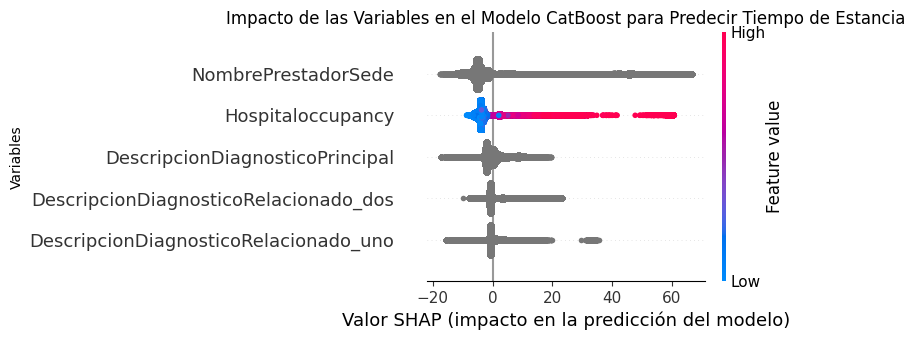

Importancia promedio de las variables (SHAP):
                               Variables  Importancia SHAP Promedio
0                    NombrePrestadorSede                   9.203436
4                      Hospitaloccupancy                   5.404814
1        DescripcionDiagnosticoPrincipal                   2.144406
3  DescripcionDiagnosticoRelacionado_dos                   1.579747
2  DescripcionDiagnosticoRelacionado_uno                   1.357472


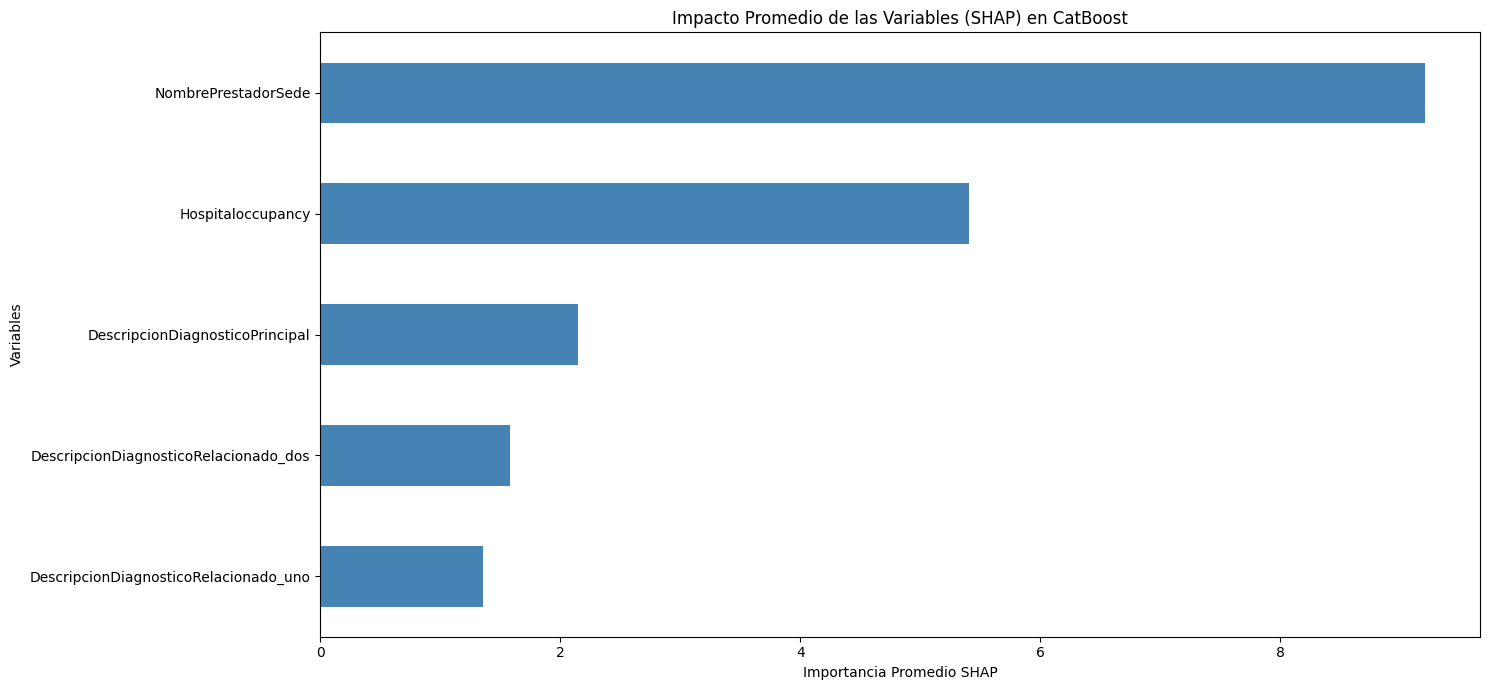

In [5]:
import joblib 
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
model_catboost = joblib.load(model_save_path_catboost)

# Definir las columnas categóricas
categorical_columns = ['NombrePrestadorSede', 'DescripcionDiagnosticoPrincipal', 
                       'DescripcionDiagnosticoRelacionado_uno']

# Seleccionar todos los datos de entrada
X_combined = X.copy()

# Convertir las variables categóricas a tipo 'category'
for col in categorical_columns:
    X_combined[col] = X_combined[col].astype('category')

# Aplicar SHAP para CatBoost
explainer_catboost = shap.TreeExplainer(model_catboost)
shap_values_catboost = explainer_catboost.shap_values(X_combined)

# Crear el gráfico de resumen de SHAP
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values_catboost, X_combined, show=False)
plt.title('Impacto de las Variables en el Modelo CatBoost para Predecir Tiempo de Estancia')
plt.xlabel('Valor SHAP (impacto en la predicción del modelo)')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

# Obtener la importancia promedio de cada característica en CatBoost
mean_shap_catboost = np.abs(shap_values_catboost).mean(axis=0)

# Crear un DataFrame para la importancia de características en CatBoost
shap_df_catboost = pd.DataFrame({
    'Variables': X_combined.columns,  # Cambiar 'Features' por 'Variables'
    'Importancia SHAP Promedio': mean_shap_catboost  # Cambiar 'SHAP Mean Importance'
}).sort_values(by='Importancia SHAP Promedio', ascending=False)

# Mostrar los valores promedio exactos
print("Importancia promedio de las variables (SHAP):")
print(shap_df_catboost)

# Graficar la importancia promedio de las características en CatBoost
shap_df_catboost.set_index('Variables').plot(kind='barh', figsize=(15, 7), legend=False, color='steelblue')
plt.title("Impacto Promedio de las Variables (SHAP) en CatBoost")
plt.xlabel("Importancia Promedio SHAP")
plt.ylabel("Variables")
plt.gca().invert_yaxis()  # Invertir el eje Y para que las características más importantes estén en la parte superior
plt.tight_layout()
plt.show()









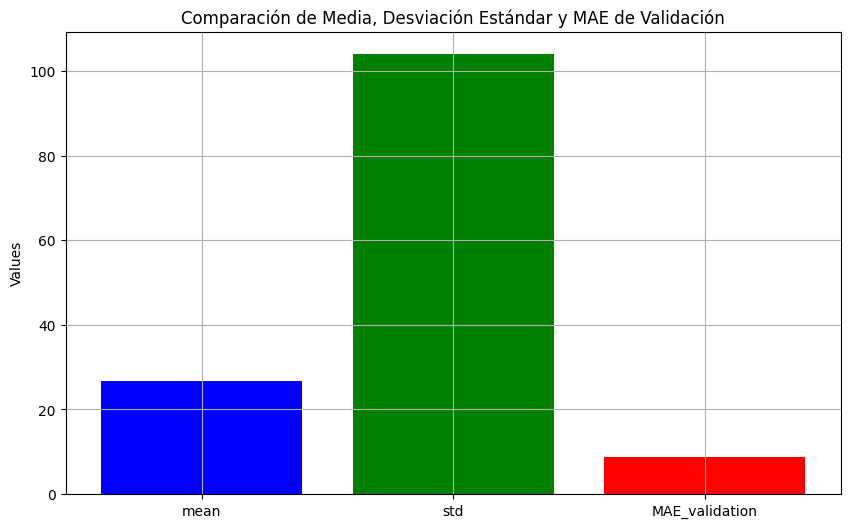

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Simulamos los resultados de y.describe() con las nuevas estadísticas
data_description = {
    'mean': 26.80,
    'std': 103.95,
    'min': 0.5,
    '25%': 2.67,
    '50%': 5.55,
    '75%': 15.70,
    'max': 15938.28
}

# Creamos un DataFrame con estos datos
y_stats = pd.DataFrame(data_description, index=['TiempoenUrgencias'])

# MAE de validación
mae_validation = 8.8400

# Agregamos el MAE al DataFrame
y_stats['MAE_validation'] = mae_validation

# Graficar la media, desviación estándar y MAE
features = ['mean', 'std', 'MAE_validation']
values = [y_stats['mean'][0], y_stats['std'][0], mae_validation]

plt.figure(figsize=(10, 6))
plt.bar(features, values, color=['blue', 'green', 'red'])
plt.ylabel('Values')
plt.title('Comparación de Media, Desviación Estándar y MAE de Validación')
plt.grid(True)
plt.show()


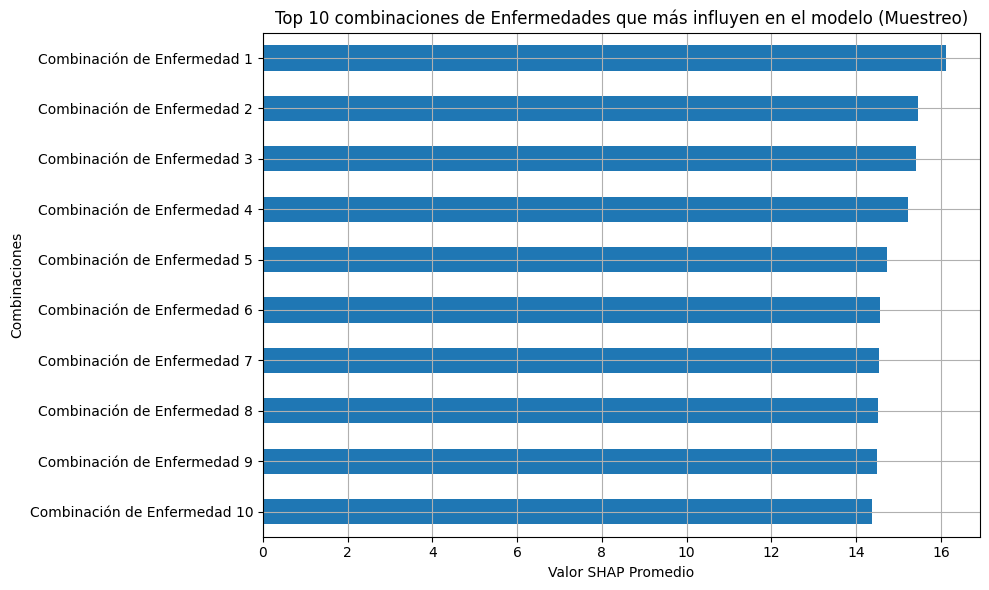

Correspondencia entre nombres genéricos y combinaciones de enfermedades reales:
            Enfermedad Genérica  \
0   Combinación de Enfermedad 1   
1   Combinación de Enfermedad 2   
2   Combinación de Enfermedad 3   
3   Combinación de Enfermedad 4   
4   Combinación de Enfermedad 5   
5   Combinación de Enfermedad 6   
6   Combinación de Enfermedad 7   
7   Combinación de Enfermedad 8   
8   Combinación de Enfermedad 9   
9  Combinación de Enfermedad 10   

                                                                                                                                               Combinación Real  
0                                                                     (Tuberculosis, Enfermedad por virus de inmunodeficiencia humana [VIH], Diabetes mellitus)  
1                                                                                  (Anemias carenciales, Otras enfermedades del aparato digestivo, Artropatías)  
2                                               

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]

# Paso 2: Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los SHAP values solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = y_sample['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = y_sample['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = y_sample['DescripcionDiagnosticoRelacionado_dos'].values

# Paso 3: Agrupar y calcular el impacto promedio para DiagnosticoPrincipal y DiagnosticoRelacionadoUno y Dos
# Tomar el promedio de los valores SHAP
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por todas las combinaciones de diagnósticos
shap_df_comb = shap_df_sample.groupby(['DiagnosticoPrincipal', 'DiagnosticoRelacionadoUno', 'DiagnosticoRelacionadoDos'])['Promedio_SHAP'].mean()

# Filtrar las 10 combinaciones que más influyen
top_comb = shap_df_comb.nlargest(10)

# Asignar nombres genéricos para las combinaciones de enfermedades
combinaciones_genericas = [f"Combinación de Enfermedad {i+1}" for i in range(10)]

# Crear un diccionario para almacenar la correspondencia entre nombres genéricos y reales
correspondencia_enfermedades = {f"Combinación de Enfermedad {i+1}": comb for i, comb in enumerate(top_comb.index)}

# Graficar las combinaciones más influyentes con nombres genéricos y mayor valor arriba
plt.figure(figsize=(10, 6))
top_comb.index = combinaciones_genericas  # Reemplazar los nombres reales por genéricos
top_comb = top_comb.sort_values(ascending=True)  # Invertir el orden para que el mayor esté arriba
top_comb.plot(kind='barh', stacked=False)
plt.title('Top 10 combinaciones de Enfermedades que más influyen en el modelo (Muestreo)')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Combinaciones')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar la correspondencia entre nombres genéricos y reales
print("Correspondencia entre nombres genéricos y combinaciones de enfermedades reales:")

# Ajustar el entorno para que se muestre toda la tabla sin recortes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

correspondencia_df = pd.DataFrame(list(correspondencia_enfermedades.items()), columns=["Enfermedad Genérica", "Combinación Real"])
print(correspondencia_df)



#Mirar lo de como es el impacto de las enfermedades por nivel de edad.







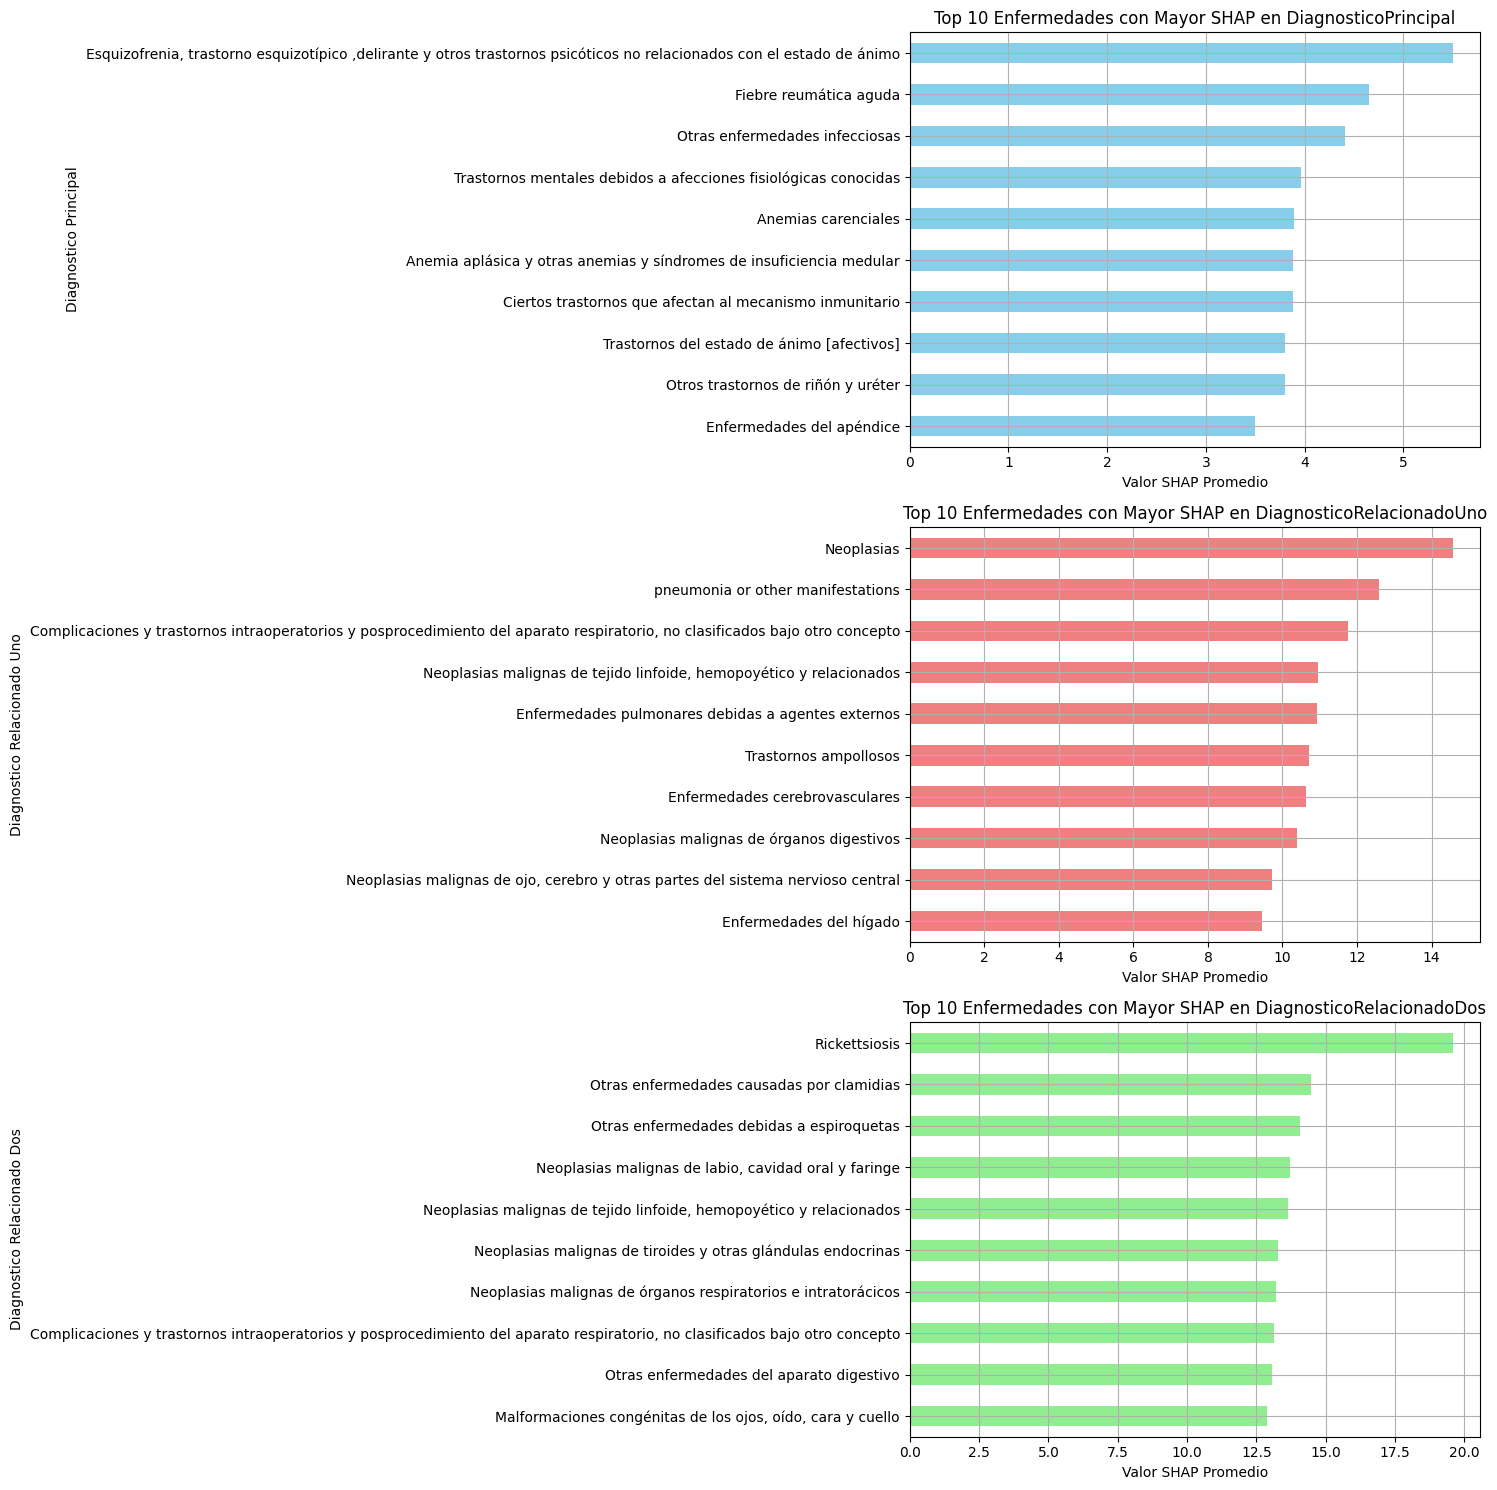

In [10]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)

# Crear una copia de X_combined para muestreo
X_combined = X.copy()
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los SHAP values para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = y_sample['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = y_sample['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = y_sample['DescripcionDiagnosticoRelacionado_dos'].values

# Calcular el valor SHAP promedio para cada diagnóstico
# DiagnosticoPrincipal
shap_df_principal = shap_df_sample.groupby('DiagnosticoPrincipal')['DescripcionDiagnosticoPrincipal'].mean().nlargest(10)

# DiagnosticoRelacionadoUno
shap_df_relacionado_uno = shap_df_sample.groupby('DiagnosticoRelacionadoUno')['DescripcionDiagnosticoRelacionado_uno'].mean().nlargest(10)

# DiagnosticoRelacionadoDos
shap_df_relacionado_dos = shap_df_sample.groupby('DiagnosticoRelacionadoDos')['DescripcionDiagnosticoRelacionado_dos'].mean().nlargest(10)

# Graficar los resultados
plt.figure(figsize=(15, 15))

# Gráfico 1: Top 10 enfermedades para DiagnosticoPrincipal
plt.subplot(3, 1, 1)
shap_df_principal.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Top 10 Enfermedades con Mayor SHAP en DiagnosticoPrincipal')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Diagnostico Principal')
plt.grid(True)

# Gráfico 2: Top 10 enfermedades para DiagnosticoRelacionadoUno
plt.subplot(3, 1, 2)
shap_df_relacionado_uno.sort_values(ascending=True).plot(kind='barh', color='lightcoral')
plt.title('Top 10 Enfermedades con Mayor SHAP en DiagnosticoRelacionadoUno')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Diagnostico Relacionado Uno')
plt.grid(True)

# Gráfico 3: Top 10 enfermedades para DiagnosticoRelacionadoDos
plt.subplot(3, 1, 3)
shap_df_relacionado_dos.sort_values(ascending=True).plot(kind='barh', color='lightgreen')
plt.title('Top 10 Enfermedades con Mayor SHAP en DiagnosticoRelacionadoDos')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Diagnostico Relacionado Dos')
plt.grid(True)

plt.tight_layout()
plt.show()


c:\Users\jpcan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


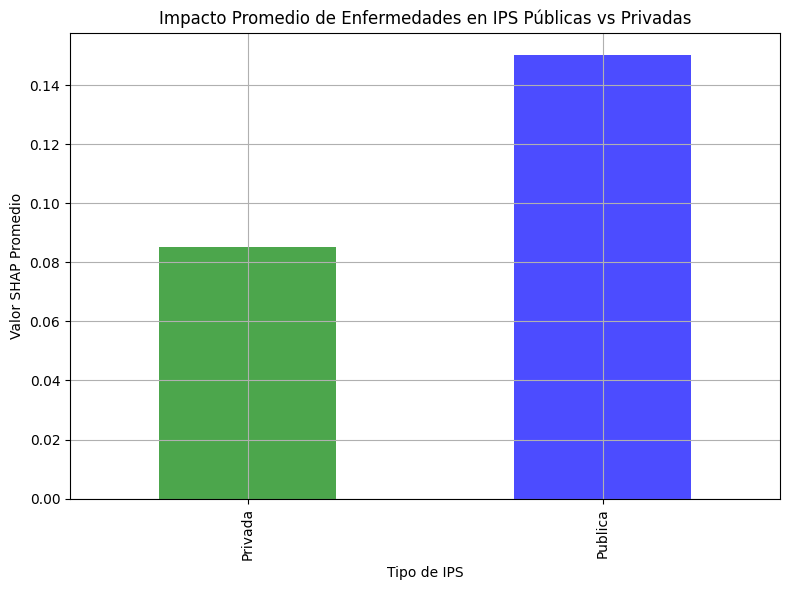

Impacto promedio de enfermedades en IPS Públicas vs Privadas:
TipoDeIPS
Privada    0.085139
Publica    0.150169
Name: Promedio_SHAP, dtype: float64


In [4]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)

# Definir las IPS públicas
ips_publicas = [
    'EMPRESA SOCIAL DEL ESTADO METROSALUD',
    'HOSPITAL ALMA MÁTER DE ANTIOQUIA',
    'HOSPITAL GENERAL DE MEDELLIN',
    'ESE HOSPITAL LA MARIA'
]
X_combined = X.copy()
# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 'NombrePrestadorSede']]

# Determinar si cada entrada corresponde a una IPS pública o privada
y_sample['TipoDeIPS'] = y_sample['NombrePrestadorSede'].apply(lambda x: 'Publica' if any(ips in x for ips in ips_publicas) else 'Privada')

# Paso 2: Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los SHAP values solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = y_sample['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = y_sample['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = y_sample['DescripcionDiagnosticoRelacionado_dos'].values
shap_df_sample['TipoDeIPS'] = y_sample['TipoDeIPS'].values  # Añadir la columna de tipo de IPS

# Paso 3: Calcular el impacto promedio para cada tipo de IPS (pública o privada)
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por tipo de IPS y calcular el promedio de SHAP values para cada tipo
shap_promedio_por_tipo = shap_df_sample.groupby('TipoDeIPS')['Promedio_SHAP'].mean()

# Graficar el impacto promedio de las enfermedades en IPS públicas y privadas
plt.figure(figsize=(8, 6))
shap_promedio_por_tipo.plot(kind='bar', color=['green', 'blue'], alpha=0.7)
plt.title('Impacto Promedio de Enfermedades en IPS Públicas vs Privadas')
plt.xlabel('Tipo de IPS')
plt.ylabel('Valor SHAP Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de cada tipo de IPS
print("Impacto promedio de enfermedades en IPS Públicas vs Privadas:")
print(shap_promedio_por_tipo)


C:\Users\jpcan\AppData\Local\Temp\ipykernel_12388\1204415087.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


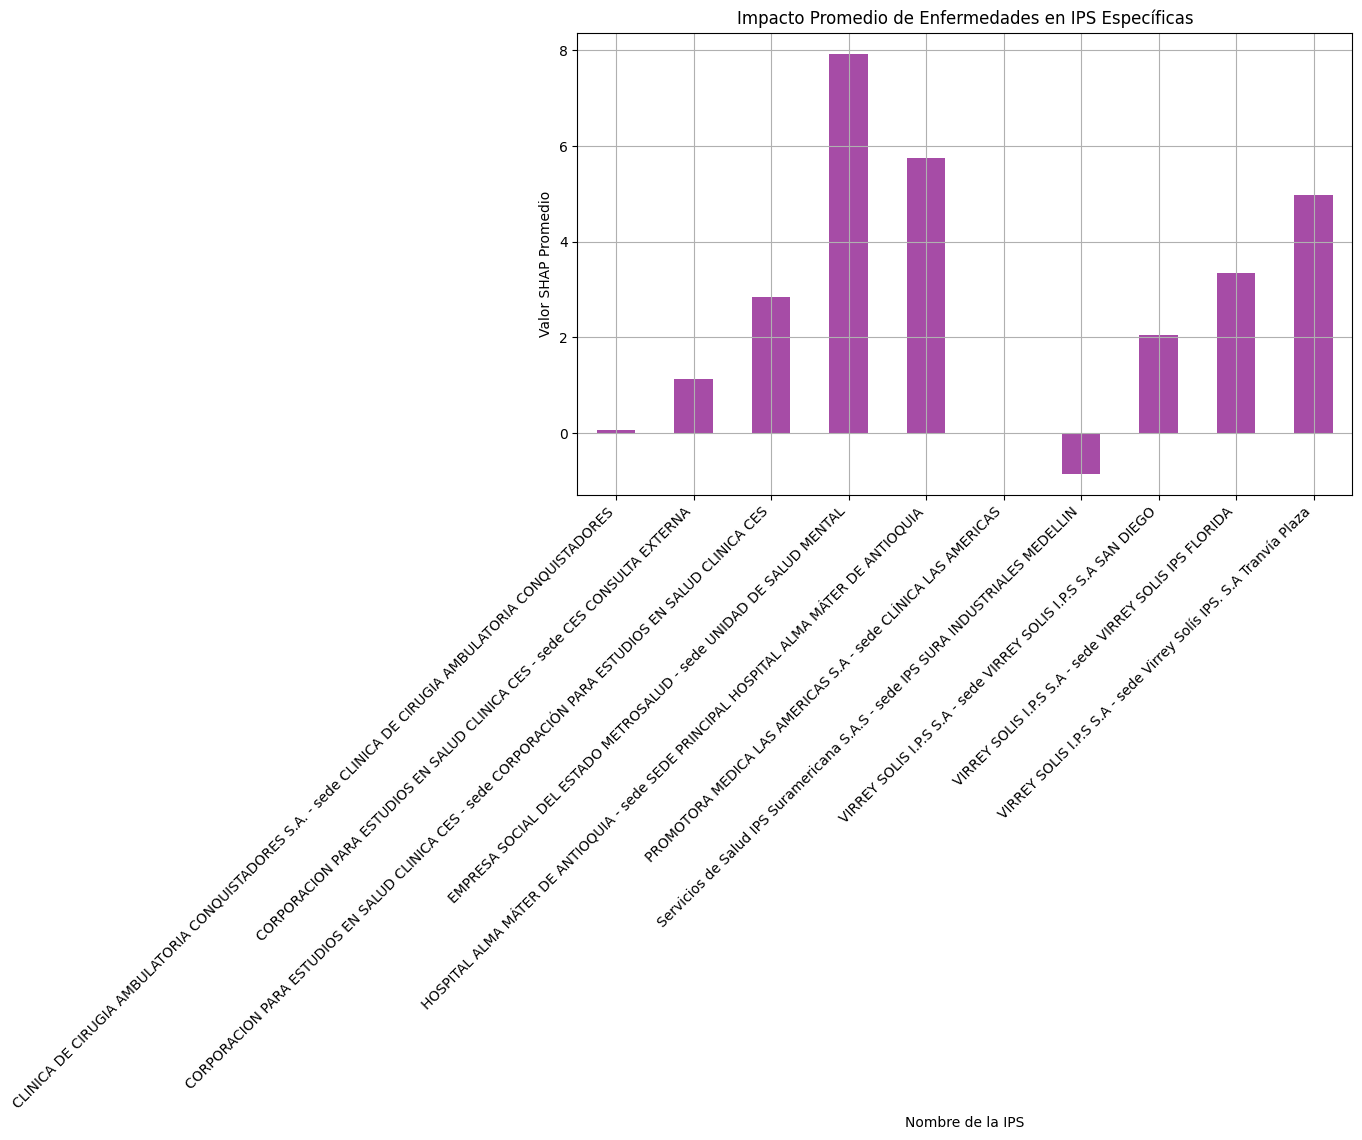

Impacto promedio de enfermedades en IPS específicas:
NombrePrestadorSede
CLINICA DE CIRUGIA AMBULATORIA CONQUISTADORES S.A. - sede CLINICA DE CIRUGIA AMBULATORIA CONQUISTADORES    0.062736
CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES - sede CES CONSULTA EXTERNA                                 1.131212
CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES - sede CORPORACIÓN PARA ESTUDIOS EN SALUD CLINICA CES       2.842192
EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD DE SALUD MENTAL                                         7.925232
HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE PRINCIPAL HOSPITAL ALMA MÁTER DE ANTIOQUIA                    5.747407
PROMOTORA MEDICA LAS AMERICAS S.A - sede CLÍNICA LAS AMERICAS                                             -0.021873
Servicios de Salud IPS Suramericana S.A.S - sede IPS SURA INDUSTRIALES MEDELLIN                           -0.845700
VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS I.P.S S.A SAN DIEGO                                             2.046497

In [11]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)

# Definir las IPS específicas a analizar
ips_especificas = [
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD DE SALUD MENTAL',
    'PROMOTORA MEDICA LAS AMERICAS S.A - sede CLÍNICA LAS AMERICAS',
    'HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE PRINCIPAL HOSPITAL ALMA MÁTER DE ANTIOQUIA',
    'CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES - sede CORPORACIÓN PARA ESTUDIOS EN SALUD CLINICA CES',
    'VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS IPS FLORIDA',
    'CLINICA DE CIRUGIA AMBULATORIA CONQUISTADORES S.A. - sede CLINICA DE CIRUGIA AMBULATORIA CONQUISTADORES',
    'VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS I.P.S S.A SAN DIEGO',
    'VIRREY SOLIS I.P.S S.A - sede Virrey Solís IPS. S.A Tranvía Plaza',
    'CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES - sede CES CONSULTA EXTERNA',
    'Servicios de Salud IPS Suramericana S.A.S - sede IPS SURA INDUSTRIALES MEDELLIN'
]

# Crear una copia de X_combined para muestreo
X_combined = X.copy()
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 'NombrePrestadorSede']]

# Filtrar para incluir solo las IPS específicas
y_sample = y_sample[y_sample['NombrePrestadorSede'].isin(ips_especificas)]

# Paso 2: Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample.loc[y_sample.index])

# Crear un DataFrame con los SHAP values solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = y_sample['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = y_sample['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = y_sample['DescripcionDiagnosticoRelacionado_dos'].values
shap_df_sample['NombrePrestadorSede'] = y_sample['NombrePrestadorSede'].values  # Añadir la columna de IPS específica

# Paso 3: Calcular el impacto promedio para cada IPS específica
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por IPS específica y calcular el promedio de SHAP values para cada IPS
shap_promedio_por_ips = shap_df_sample.groupby('NombrePrestadorSede')['Promedio_SHAP'].mean()

# Graficar el impacto promedio de las enfermedades en las IPS específicas
plt.figure(figsize=(10, 6))
shap_promedio_por_ips.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Impacto Promedio de Enfermedades en IPS Específicas')
plt.xlabel('Nombre de la IPS')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de cada IPS específica
print("Impacto promedio de enfermedades en IPS específicas:")
print(shap_promedio_por_ips)



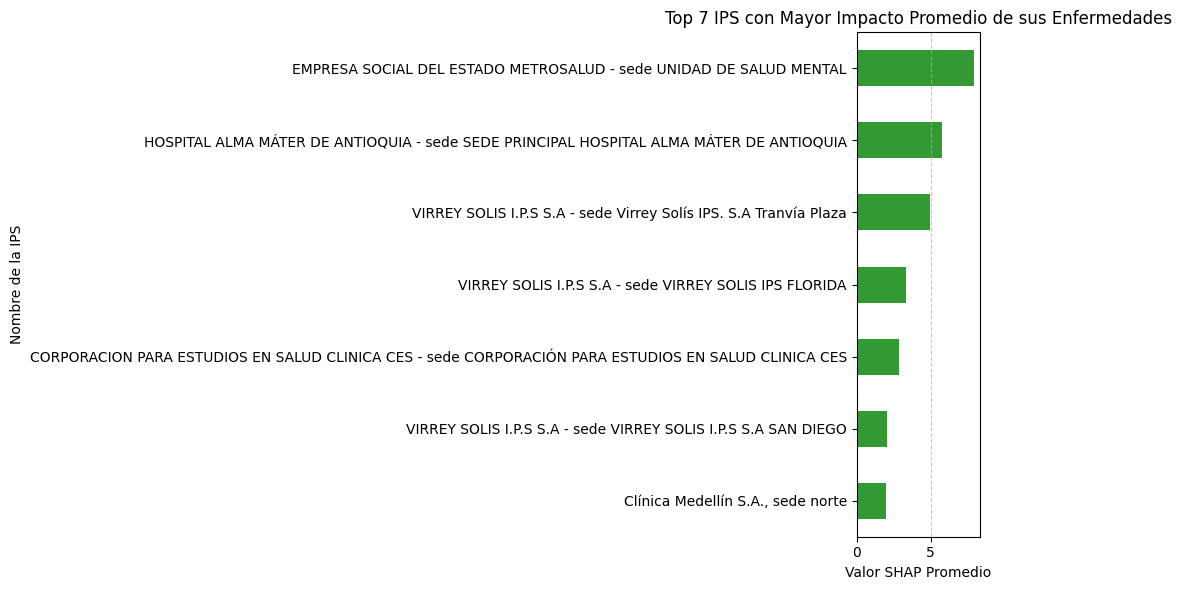

Top 7 IPS con mayor impacto promedio de enfermedades:
NombrePrestadorSede
EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD DE SALUD MENTAL                                      7.925232
HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE PRINCIPAL HOSPITAL ALMA MÁTER DE ANTIOQUIA                 5.747407
VIRREY SOLIS I.P.S S.A - sede Virrey Solís IPS. S.A Tranvía Plaza                                       4.974846
VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS IPS FLORIDA                                                  3.334517
CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES - sede CORPORACIÓN PARA ESTUDIOS EN SALUD CLINICA CES    2.842192
VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS I.P.S S.A SAN DIEGO                                          2.046497
Clínica Medellín S.A., sede norte                                                                       1.982354
Name: Promedio_SHAP, dtype: float64


In [11]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)

# Crear una copia de X_combined para muestreo
X_combined = X.copy()
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 'NombrePrestadorSede']]

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample.loc[y_sample.index])

# Crear un DataFrame con los SHAP values solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = y_sample['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = y_sample['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = y_sample['DescripcionDiagnosticoRelacionado_dos'].values
shap_df_sample['NombrePrestadorSede'] = y_sample['NombrePrestadorSede'].values  # Añadir la columna de IPS específica

# Calcular el promedio de los valores SHAP para las columnas de diagnóstico
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por IPS y calcular el promedio de SHAP values para cada IPS
shap_promedio_por_ips = shap_df_sample.groupby('NombrePrestadorSede')['Promedio_SHAP'].mean()

# Seleccionar las 7 IPS con mayor impacto promedio
top_7_ips = shap_promedio_por_ips.nlargest(7)

# Graficar el impacto promedio de las enfermedades en las 7 IPS con mayor impacto
plt.figure(figsize=(10, 6))
top_7_ips.sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.8)
plt.title('Top 7 IPS con Mayor Impacto Promedio de sus Enfermedades')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Nombre de la IPS')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de las 7 IPS con mayor impacto
print("Top 7 IPS con mayor impacto promedio de enfermedades:")
print(top_7_ips)



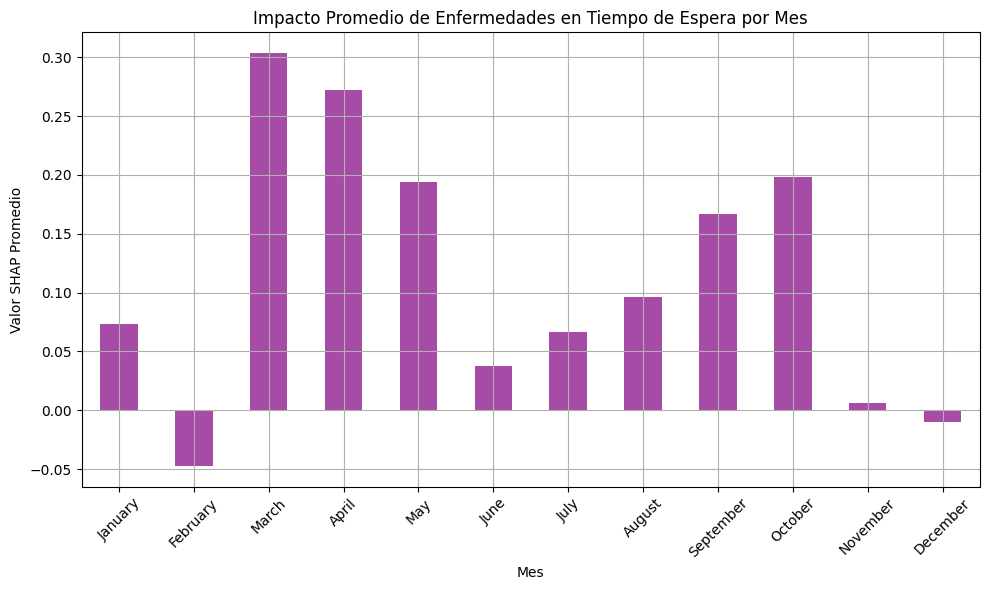

Impacto promedio de enfermedades en tiempo de espera por mes:
Mes
January      0.073079
February    -0.047194
March        0.303590
April        0.272541
May          0.193950
June         0.038076
July         0.066704
August       0.096257
September    0.166681
October      0.198416
November     0.006343
December    -0.010043
Name: Promedio_SHAP, dtype: float64


In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()
# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información del mes y diagnósticos
X_dos = df.loc[X_sample.index, ['FechaIngreso', 'DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].copy()

# Asegurarse de que 'FechaIngreso' esté en formato datetime y extraer el mes
X_dos['FechaIngreso'] = pd.to_datetime(X_dos['FechaIngreso'], errors='coerce')
X_dos['Mes'] = X_dos['FechaIngreso'].dt.month_name()

# Paso 2: Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los SHAP values solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = X_dos['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = X_dos['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = X_dos['DescripcionDiagnosticoRelacionado_dos'].values
shap_df_sample['Mes'] = X_dos['Mes'].values  # Añadir la columna del mes

# Paso 3: Calcular el impacto promedio para cada mes
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por mes y calcular el promedio de SHAP values para cada mes
shap_promedio_por_mes = shap_df_sample.groupby('Mes')['Promedio_SHAP'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])  # Ordenar por meses

# Graficar el impacto promedio de las enfermedades por mes
plt.figure(figsize=(10, 6))
shap_promedio_por_mes.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Impacto Promedio de Enfermedades en Tiempo de Espera por Mes')
plt.xlabel('Mes')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de cada mes
print("Impacto promedio de enfermedades en tiempo de espera por mes:")
print(shap_promedio_por_mes)


In [16]:
import pandas as pd
import shap
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información del mes y enfermedades
X_dos = df.loc[X_sample.index, ['FechaIngreso', 'DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].copy()

# Asegurarse de que 'FechaIngreso' esté en formato datetime y extraer el mes
X_dos['FechaIngreso'] = pd.to_datetime(X_dos['FechaIngreso'], errors='coerce')
X_dos['Mes'] = X_dos['FechaIngreso'].dt.month_name()

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los valores SHAP y añadir columnas de mes y diagnósticos
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)
shap_df_sample['Mes'] = X_dos['Mes'].values  # Añadir la columna del mes
shap_df_sample['DescripcionDiagnosticoPrincipal'] = X_dos['DescripcionDiagnosticoPrincipal'].values  # Añadir el diagnóstico principal
shap_df_sample['DescripcionDiagnosticoRelacionado_uno'] = X_dos['DescripcionDiagnosticoRelacionado_uno'].values  # Añadir el diagnóstico relacionado uno
shap_df_sample['DescripcionDiagnosticoRelacionado_dos'] = X_dos['DescripcionDiagnosticoRelacionado_dos'].values  # Añadir el diagnóstico relacionado dos

# Calcular el promedio de los valores SHAP en cada fila solo en las columnas numéricas
shap_numeric_cols = shap_df_sample.select_dtypes(include=[np.number]).columns
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_numeric_cols].mean(axis=1)

# Filtrar datos para los meses de marzo y abril
shap_marzo = shap_df_sample[shap_df_sample['Mes'] == 'March']
shap_abril = shap_df_sample[shap_df_sample['Mes'] == 'April']

# Calcular el impacto promedio de cada diagnóstico principal en marzo
top_enfermedades_marzo_principal = shap_marzo.groupby('DescripcionDiagnosticoPrincipal')['Promedio_SHAP'].mean().nlargest(10)
top_enfermedades_abril_principal = shap_abril.groupby('DescripcionDiagnosticoPrincipal')['Promedio_SHAP'].mean().nlargest(10)

# Calcular el impacto promedio de cada diagnóstico relacionado uno en marzo
top_enfermedades_marzo_uno = shap_marzo.groupby('DescripcionDiagnosticoRelacionado_uno')['Promedio_SHAP'].mean().nlargest(10)
top_enfermedades_abril_uno = shap_abril.groupby('DescripcionDiagnosticoRelacionado_uno')['Promedio_SHAP'].mean().nlargest(10)

# Calcular el impacto promedio de cada diagnóstico relacionado dos en marzo
top_enfermedades_marzo_dos = shap_marzo.groupby('DescripcionDiagnosticoRelacionado_dos')['Promedio_SHAP'].mean().nlargest(10)
top_enfermedades_abril_dos = shap_abril.groupby('DescripcionDiagnosticoRelacionado_dos')['Promedio_SHAP'].mean().nlargest(10)

# Mostrar resultados
print("Top 10 enfermedades (Diagnóstico Principal) que más impactan el valor SHAP en Marzo:")
print(top_enfermedades_marzo_principal)
print("\nTop 10 enfermedades (Diagnóstico Relacionado Uno) que más impactan el valor SHAP en Marzo:")
print(top_enfermedades_marzo_uno)
print("\nTop 10 enfermedades (Diagnóstico Relacionado Dos) que más impactan el valor SHAP en Marzo:")
print(top_enfermedades_marzo_dos)

print("\nTop 10 enfermedades (Diagnóstico Principal) que más impactan el valor SHAP en Abril:")
print(top_enfermedades_abril_principal)
print("\nTop 10 enfermedades (Diagnóstico Relacionado Uno) que más impactan el valor SHAP en Abril:")
print(top_enfermedades_abril_uno)
print("\nTop 10 enfermedades (Diagnóstico Relacionado Dos) que más impactan el valor SHAP en Abril:")
print(top_enfermedades_abril_dos)



Top 10 enfermedades (Diagnóstico Principal) que más impactan el valor SHAP en Marzo:
DescripcionDiagnosticoPrincipal
Ciclista lesionado en accidente de transporte                 32.937672
Rickettsiosis                                                 25.970174
Trastornos de conjuntiva                                      19.575003
Enfermedades del oído medio y mastoides                       17.687919
Enfermedades del ojo y sus anexos                             16.715321
Pediculosis, acariasis y otras infestaciones                  16.212581
Ciertas zoonosis bacterianas                                  15.496612
Enteritis y colitis no infecciosas                            14.847173
Malformaciones congénitas de los ojos, oído, cara y cuello    14.771989
Otras enfermedades del tracto respiratorio superior           14.524137
Name: Promedio_SHAP, dtype: float64

Top 10 enfermedades (Diagnóstico Relacionado Uno) que más impactan el valor SHAP en Marzo:
DescripcionDiagnosticoRelacionado_u

C:\Users\jpcan\AppData\Local\Temp\ipykernel_44320\1783900793.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_shap_por_grupo = shap_df_sample.groupby('GrupoEtario')['Promedio_SHAP'].mean()


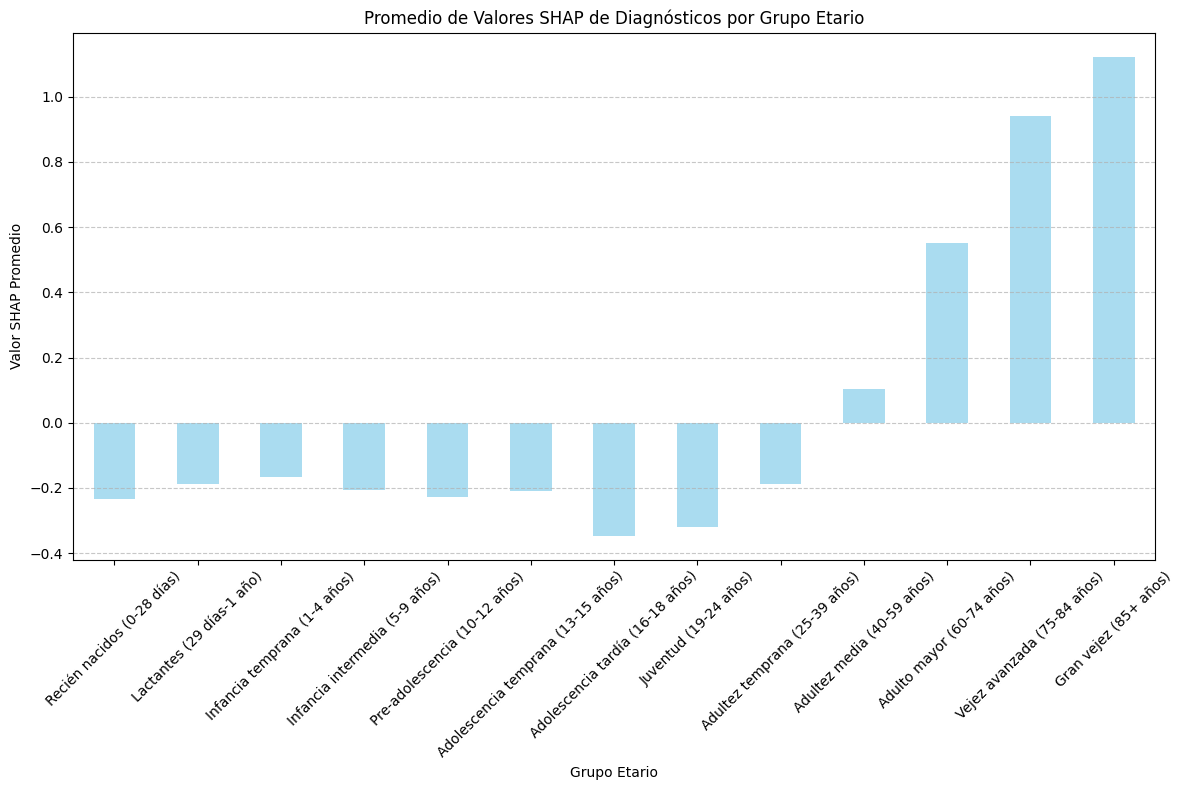

Promedio de valores SHAP de diagnósticos por grupo etario:
GrupoEtario
Recién nacidos (0-28 días)           -0.233247
Lactantes (29 días-1 año)            -0.188685
Infancia temprana (1-4 años)         -0.167255
Infancia intermedia (5-9 años)       -0.206874
Pre-adolescencia (10-12 años)        -0.227939
Adolescencia temprana (13-15 años)   -0.210692
Adolescencia tardía (16-18 años)     -0.346117
Juventud (19-24 años)                -0.319756
Adultez temprana (25-39 años)        -0.187546
Adultez media (40-59 años)            0.102765
Adulto mayor (60-74 años)             0.552615
Vejez avanzada (75-84 años)           0.942080
Gran vejez (85+ años)                 1.122374
Name: Promedio_SHAP, dtype: float64


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
import numpy as np

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información de Edad
X_dos = df.loc[X_sample.index, ['Edad']].copy()

# Definir los rangos de edad y etiquetas de grupo etario
bins = [0, 28/365, 1, 4, 9, 12, 15, 18, 24, 39, 59, 74, 84, 110]  # Límites de edad en años
labels = [
    'Recién nacidos (0-28 días)', 'Lactantes (29 días-1 año)', 'Infancia temprana (1-4 años)',
    'Infancia intermedia (5-9 años)', 'Pre-adolescencia (10-12 años)', 'Adolescencia temprana (13-15 años)',
    'Adolescencia tardía (16-18 años)', 'Juventud (19-24 años)', 'Adultez temprana (25-39 años)',
    'Adultez media (40-59 años)', 'Adulto mayor (60-74 años)', 'Vejez avanzada (75-84 años)', 'Gran vejez (85+ años)'
]

# Asignar el grupo etario según la columna 'Edad'
X_dos['GrupoEtario'] = pd.cut(X_dos['Edad'], bins=bins, labels=labels, right=False)

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los valores SHAP solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[
    ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']
]
shap_df_sample['GrupoEtario'] = X_dos['GrupoEtario'].values  # Añadir la columna del grupo etario

# Calcular el promedio de los valores SHAP solo en las columnas de diagnóstico
shap_columns = ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_columns].mean(axis=1)

# Agrupar por grupo etario y calcular el promedio de los valores SHAP
promedio_shap_por_grupo = shap_df_sample.groupby('GrupoEtario')['Promedio_SHAP'].mean()

# Graficar el impacto promedio de SHAP por grupo etario
plt.figure(figsize=(12, 8))
promedio_shap_por_grupo.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Promedio de Valores SHAP de Diagnósticos por Grupo Etario')
plt.xlabel('Grupo Etario')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar los valores de impacto promedio de SHAP por grupo etario
print("Promedio de valores SHAP de diagnósticos por grupo etario:")
print(promedio_shap_por_grupo)



C:\Users\jpcan\AppData\Local\Temp\ipykernel_17312\2034266315.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


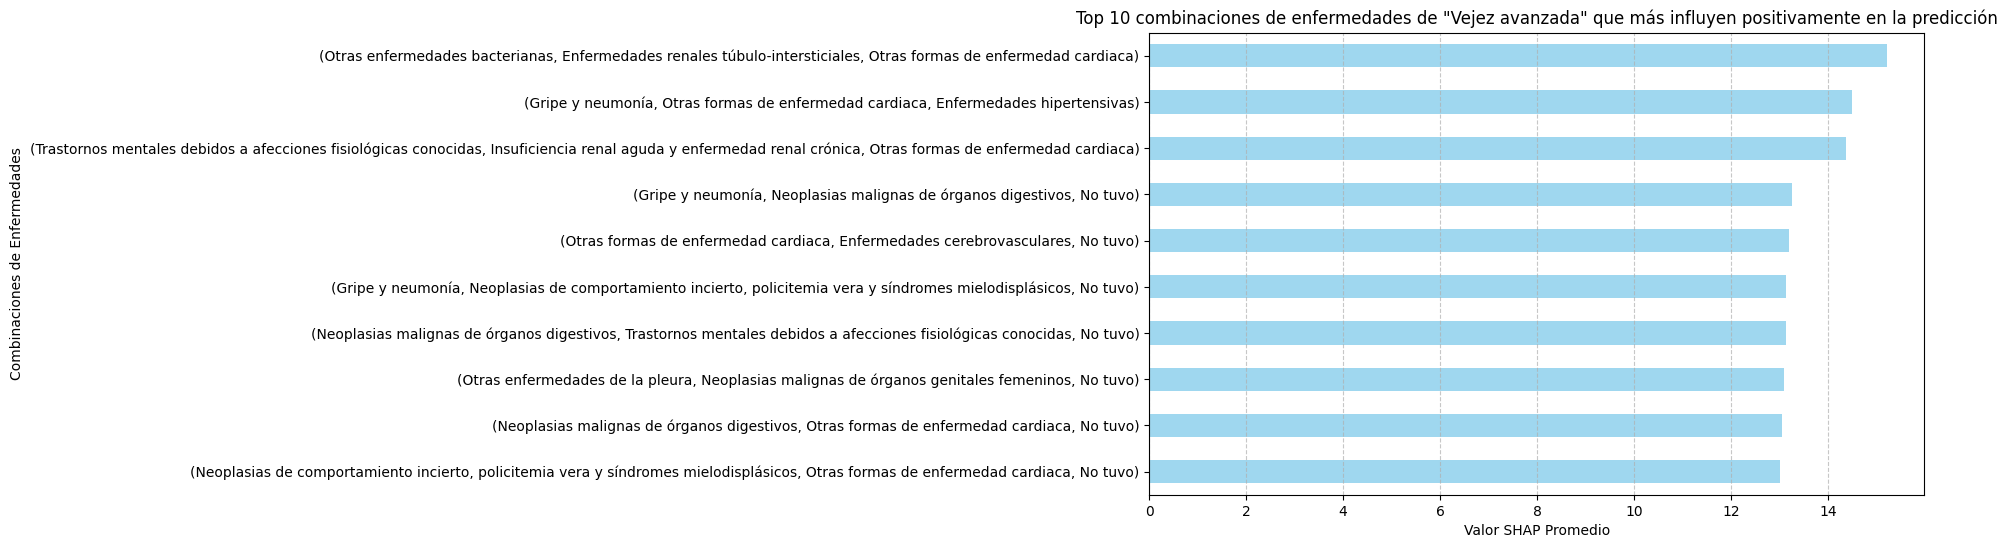

Correspondencia entre nombres genéricos y combinaciones de enfermedades reales:
            Enfermedad Genérica  \
0   Combinación de Enfermedad 1   
1   Combinación de Enfermedad 2   
2   Combinación de Enfermedad 3   
3   Combinación de Enfermedad 4   
4   Combinación de Enfermedad 5   
5   Combinación de Enfermedad 6   
6   Combinación de Enfermedad 7   
7   Combinación de Enfermedad 8   
8   Combinación de Enfermedad 9   
9  Combinación de Enfermedad 10   

                                    Combinación Real  
0  (Otras enfermedades bacterianas, Enfermedades ...  
1  (Gripe y neumonía, Otras formas de enfermedad ...  
2  (Trastornos mentales debidos a afecciones fisi...  
3  (Gripe y neumonía, Neoplasias malignas de órga...  
4  (Otras formas de enfermedad cardiaca, Enfermed...  
5  (Gripe y neumonía, Neoplasias de comportamient...  
6  (Neoplasias malignas de órganos digestivos, Tr...  
7  (Otras enfermedades de la pleura, Neoplasias m...  
8  (Neoplasias malignas de órganos dige

In [5]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear un muestreo de los datos
sample_size = int(len(X_combined))
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Obtener las columnas necesarias para diagnósticos y edades
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 'Edad']]

# Definir los rangos de edad y etiquetas de grupo etario
bins = [0, 28/365, 1, 4, 9, 12, 15, 18, 24, 39, 59, 74, 84, 110]  # Límites de edad en años
labels = [
    'Recién nacidos (0-28 días)', 'Lactantes (29 días-1 año)', 'Infancia temprana (1-4 años)',
    'Infancia intermedia (5-9 años)', 'Pre-adolescencia (10-12 años)', 'Adolescencia temprana (13-15 años)',
    'Adolescencia tardía (16-18 años)', 'Juventud (19-24 años)', 'Adultez temprana (25-39 años)',
    'Adultez media (40-59 años)', 'Adulto mayor (60-74 años)', 'Vejez avanzada (75-84 años)', 'Gran vejez (85+ años)'
]
y_sample['GrupoEtario'] = pd.cut(y_sample['Edad'], bins=bins, labels=labels, right=False)

# Filtrar el grupo "Vejez avanzada"
grupo_vejez_avanzada = y_sample[y_sample['GrupoEtario'] == 'Gran vejez (85+ años)']

# Calcular los valores SHAP para el modelo CatBoost en el muestreo filtrado
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample.loc[grupo_vejez_avanzada.index])

# Crear un DataFrame con los valores SHAP solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = grupo_vejez_avanzada['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = grupo_vejez_avanzada['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = grupo_vejez_avanzada['DescripcionDiagnosticoRelacionado_dos'].values

# Calcular el promedio de los valores SHAP para las combinaciones de diagnósticos
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por combinaciones de diagnósticos y calcular el promedio de los valores SHAP
shap_df_comb = shap_df_sample.groupby(['DiagnosticoPrincipal', 'DiagnosticoRelacionadoUno', 'DiagnosticoRelacionadoDos'])['Promedio_SHAP'].mean()

# Seleccionar las 10 combinaciones más influyentes
top_comb = shap_df_comb.nlargest(10)

# Graficar las combinaciones más influyentes
plt.figure(figsize=(10, 6))
top_comb.sort_values(ascending=True).plot(kind='barh', color='skyblue', alpha=0.8)
plt.title('Top 10 combinaciones de enfermedades de "Vejez avanzada" que más influyen positivamente en la predicción')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Combinaciones de Enfermedades')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar las combinaciones más influyentes con nombres genéricos
combinaciones_genericas = [f"Combinación de Enfermedad {i+1}" for i in range(10)]
correspondencia_enfermedades = {f"Combinación de Enfermedad {i+1}": comb for i, comb in enumerate(top_comb.index)}

# Crear un DataFrame con la correspondencia
correspondencia_df = pd.DataFrame(list(correspondencia_enfermedades.items()), columns=["Enfermedad Genérica", "Combinación Real"])
print("Correspondencia entre nombres genéricos y combinaciones de enfermedades reales:")
print(correspondencia_df)


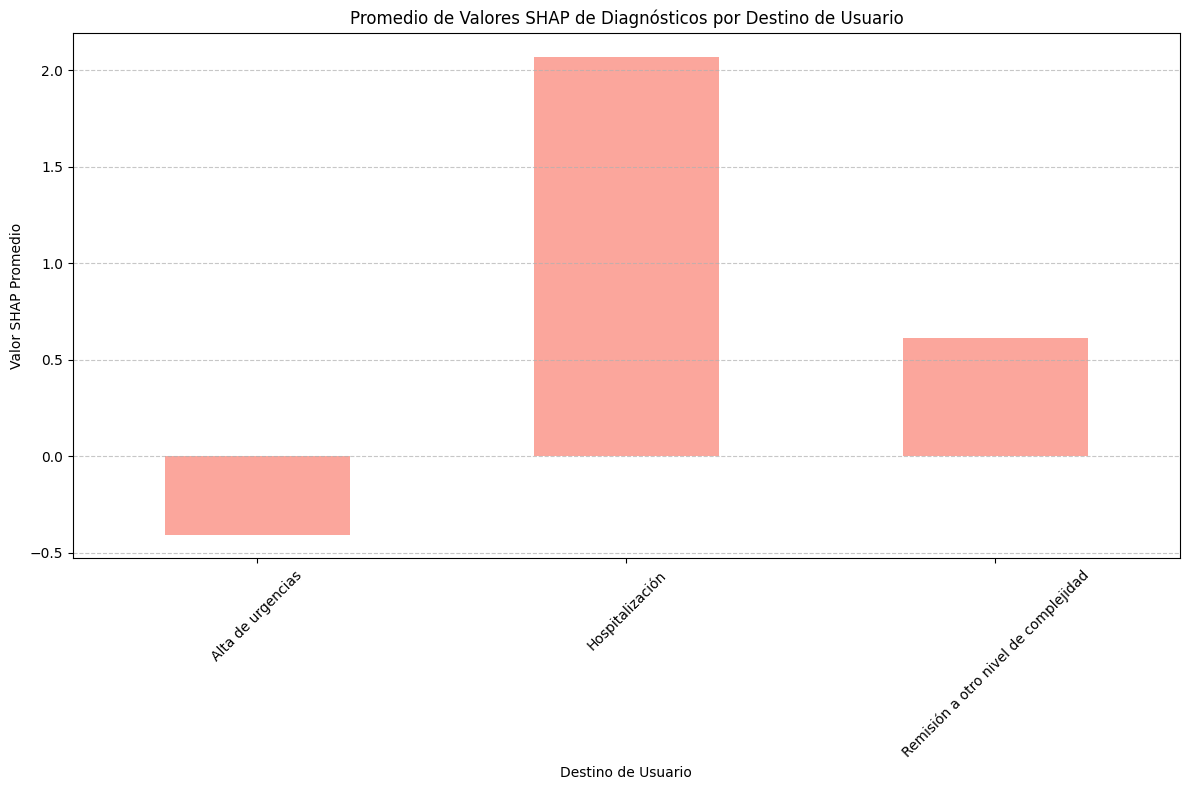

Promedio de valores SHAP de diagnósticos por Destino de Usuario:
DestinoUsuario
Alta de urgencias                      -0.405274
Hospitalización                         2.071024
Remisión a otro nivel de complejidad    0.611111
Name: Promedio_SHAP, dtype: float64


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
import numpy as np

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información de DestinoUsuario
X_dos = df.loc[X_sample.index, ['DestinoUsuario']].copy()

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los valores SHAP solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[
    ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']
]
shap_df_sample['DestinoUsuario'] = X_dos['DestinoUsuario'].values  # Añadir la columna de DestinoUsuario

# Calcular el promedio de los valores SHAP solo en las columnas de diagnóstico
shap_columns = ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_columns].mean(axis=1)

# Agrupar por DestinoUsuario y calcular el promedio de los valores SHAP
promedio_shap_por_destino = shap_df_sample.groupby('DestinoUsuario')['Promedio_SHAP'].mean()

# Graficar el impacto promedio de SHAP por DestinoUsuario
plt.figure(figsize=(12, 8))
promedio_shap_por_destino.plot(kind='bar', color='salmon', alpha=0.7)
plt.title('Promedio de Valores SHAP de Diagnósticos por Destino de Usuario')
plt.xlabel('Destino de Usuario')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar los valores de impacto promedio de SHAP por DestinoUsuario
print("Promedio de valores SHAP de diagnósticos por Destino de Usuario:")
print(promedio_shap_por_destino)


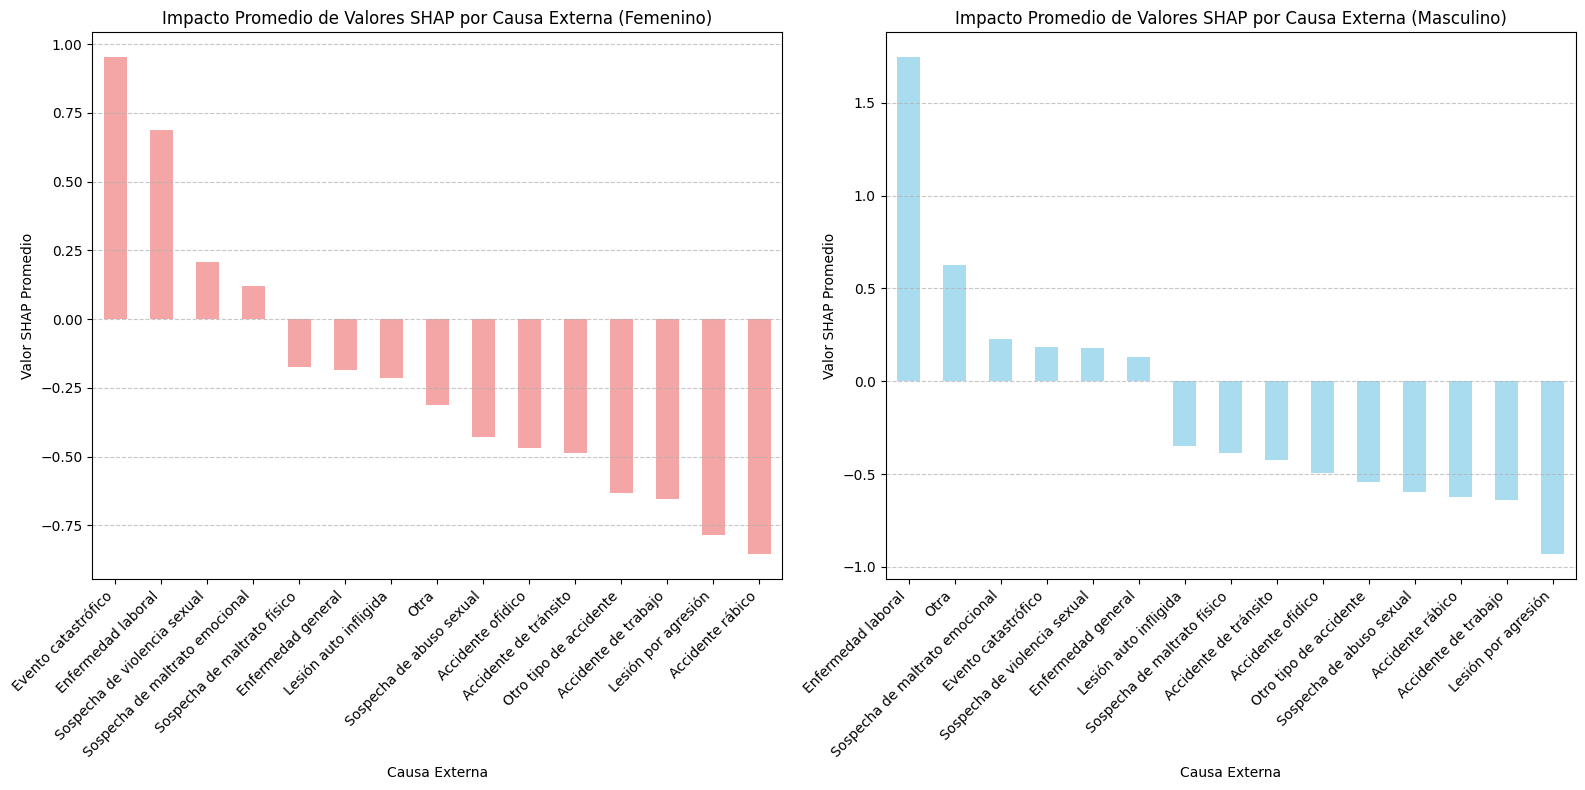

Impacto promedio de enfermedades agrupado por Causa Externa (Femenino):
CausaExterna
Evento catastrófico               0.952533
Enfermedad laboral                0.687029
Sospecha de violencia sexual      0.208872
Sospecha de maltrato emocional    0.119462
Sospecha de maltrato físico      -0.174930
Enfermedad general               -0.186714
Lesión auto infligida            -0.215793
Otra                             -0.310818
Sospecha de abuso sexual         -0.428933
Accidente ofídico                -0.467422
Accidente de tránsito            -0.485886
Otro tipo de accidente           -0.632439
Accidente de trabajo             -0.654626
Lesión por agresión              -0.784428
Accidente rábico                 -0.855014
Name: F, dtype: float64

Impacto promedio de enfermedades agrupado por Causa Externa (Masculino):
CausaExterna
Enfermedad laboral                1.745356
Otra                              0.624648
Sospecha de maltrato emocional    0.226582
Evento catastrófico           

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear un muestreo de los datos
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Obtener las columnas necesarias para CausaExterna, Sexo y Edad
X_dos = df.loc[X_sample.index, ['CausaExterna', 'Sexo', 'Edad']].copy()

# Definir los rangos de edad y etiquetas de grupo etario
bins = [0, 28/365, 1, 4, 9, 12, 15, 18, 24, 39, 59, 74, 84, 110]  # Límites de edad en años
labels = [
    'Recién nacidos (0-28 días)', 'Lactantes (29 días-1 año)', 'Infancia temprana (1-4 años)',
    'Infancia intermedia (5-9 años)', 'Pre-adolescencia (10-12 años)', 'Adolescencia temprana (13-15 años)',
    'Adolescencia tardía (16-18 años)', 'Juventud (19-24 años)', 'Adultez temprana (25-39 años)',
    'Adultez media (40-59 años)', 'Adulto mayor (60-74 años)', 'Vejez avanzada (75-84 años)', 'Gran vejez (85+ años)'
]
X_dos['GrupoEtario'] = pd.cut(X_dos['Edad'], bins=bins, labels=labels, right=False)

# Filtrar los grupos etarios excluidos
grupos_excluidos = ['Adulto mayor (60-74 años)', 'Vejez avanzada (75-84 años)', 'Gran vejez (85+ años)']
X_dos = X_dos[~X_dos['GrupoEtario'].isin(grupos_excluidos)]

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo filtrado
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample.loc[X_dos.index])

# Crear un DataFrame con los valores SHAP solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[
    ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']
]
shap_df_sample['CausaExterna'] = X_dos['CausaExterna'].values  # Añadir la columna de CausaExterna
shap_df_sample['Sexo'] = X_dos['Sexo'].values  # Añadir la columna de Sexo

# Calcular el promedio de los valores SHAP solo en las columnas de diagnóstico
shap_columns = ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_columns].mean(axis=1)

# Agrupar por CausaExterna y Sexo, calculando el promedio de SHAP
promedio_shap_por_causa_y_sexo = shap_df_sample.groupby(['Sexo', 'CausaExterna'])['Promedio_SHAP'].mean().unstack(level=0)

# Graficar el impacto promedio de SHAP por CausaExterna para cada género
plt.figure(figsize=(16, 8))

# Gráfico para Femenino
plt.subplot(1, 2, 1)
promedio_shap_por_causa_y_sexo['F'].sort_values(ascending=False).plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title('Impacto Promedio de Valores SHAP por Causa Externa (Femenino)')
plt.xlabel('Causa Externa')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Gráfico para Masculino
plt.subplot(1, 2, 2)
promedio_shap_por_causa_y_sexo['M'].sort_values(ascending=False).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Impacto Promedio de Valores SHAP por Causa Externa (Masculino)')
plt.xlabel('Causa Externa')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Mostrar los valores promedio de impacto SHAP por CausaExterna para cada género
print("Impacto promedio de enfermedades agrupado por Causa Externa (Femenino):")
print(promedio_shap_por_causa_y_sexo['F'].sort_values(ascending=False))

print("\nImpacto promedio de enfermedades agrupado por Causa Externa (Masculino):")
print(promedio_shap_por_causa_y_sexo['M'].sort_values(ascending=False))


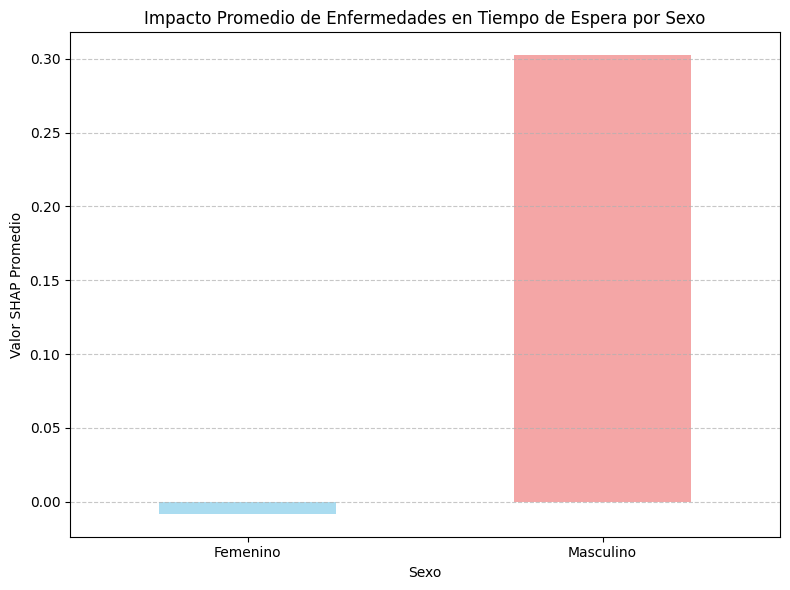

Impacto promedio de enfermedades en tiempo de espera por sexo:
Sexo
Femenino    -0.008183
Masculino    0.302308
Name: Promedio_SHAP, dtype: float64


In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)

X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información de sexo y diagnósticos
X_dos = df.loc[X_sample.index, ['Sexo', 'DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].copy()

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los SHAP values solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = X_dos['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = X_dos['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = X_dos['DescripcionDiagnosticoRelacionado_dos'].values
shap_df_sample['Sexo'] = X_dos['Sexo'].values  # Añadir la columna de Sexo

# Calcular el impacto promedio para cada sexo
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)

# Agrupar por sexo y calcular el promedio de SHAP values para cada sexo
shap_promedio_por_sexo = shap_df_sample.groupby('Sexo')['Promedio_SHAP'].mean()

# Renombrar el índice para una mejor interpretación
shap_promedio_por_sexo.index = shap_promedio_por_sexo.index.map({'M': 'Masculino', 'F': 'Femenino'})

# Graficar el impacto promedio de las enfermedades en tiempo de espera por sexo
plt.figure(figsize=(8, 6))
shap_promedio_por_sexo.plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('Impacto Promedio de Enfermedades en Tiempo de Espera por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de cada sexo
print("Impacto promedio de enfermedades en tiempo de espera por sexo:")
print(shap_promedio_por_sexo)


C:\Users\jpcan\AppData\Local\Temp\ipykernel_12388\1762497746.py:70: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


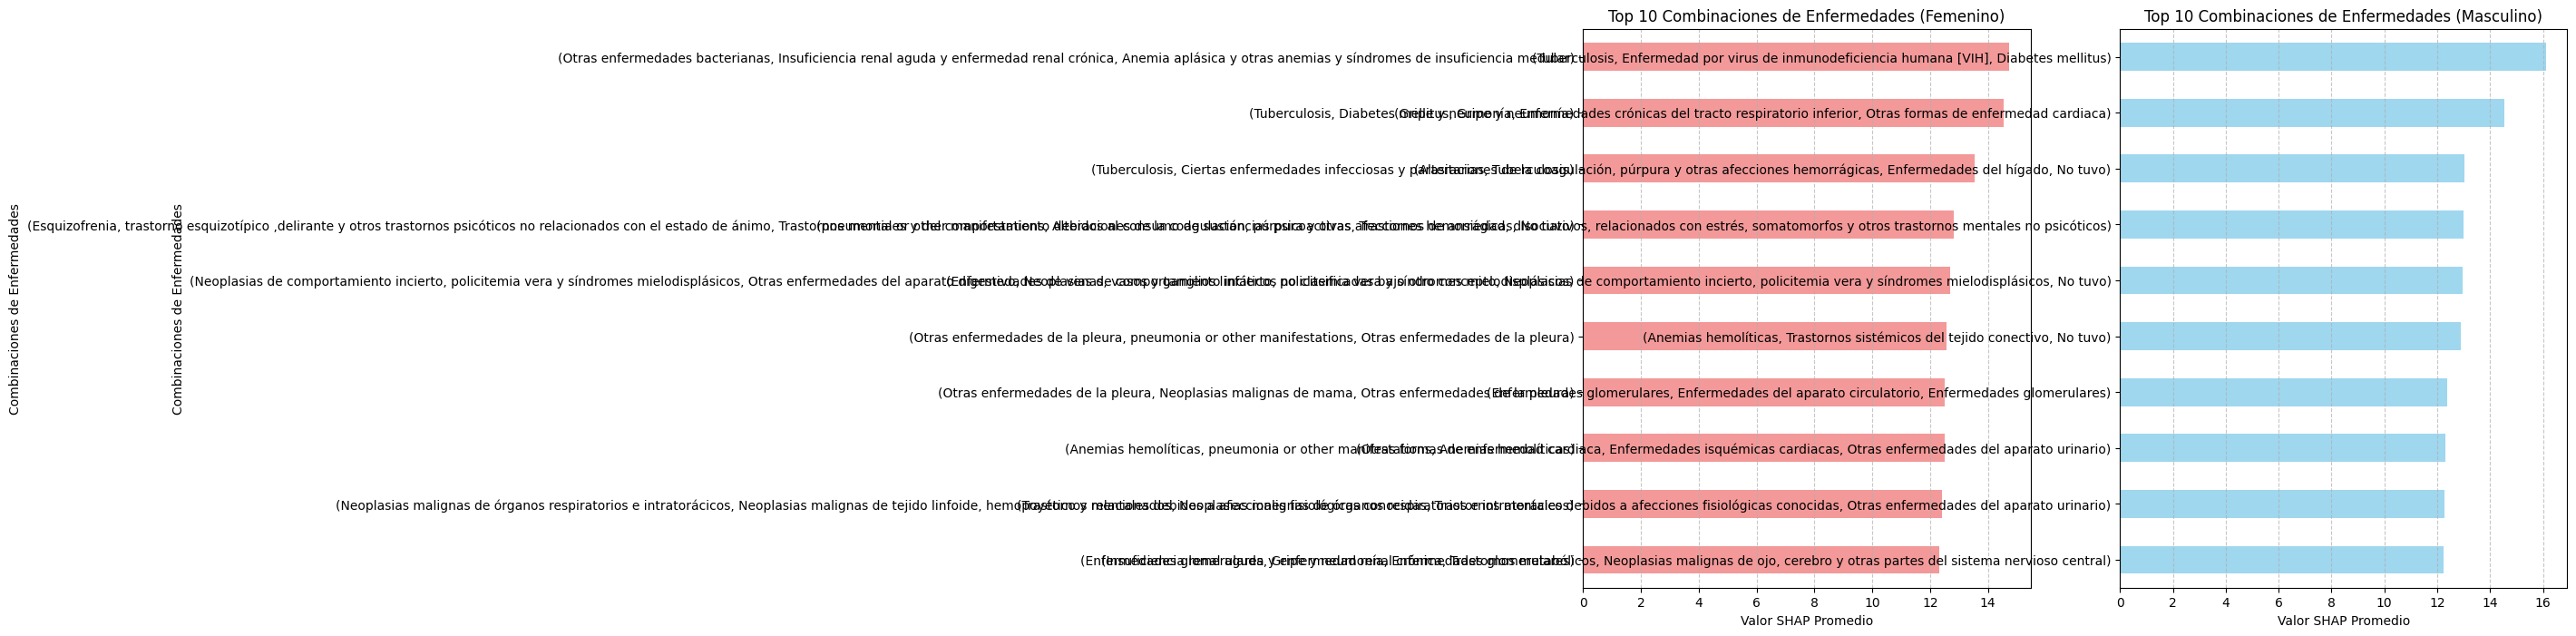

Top 10 combinaciones de enfermedades que más afectan a las mujeres:
DiagnosticoPrincipal                                                                  DiagnosticoRelacionadoUno                                                DiagnosticoRelacionadoDos                                                           
Otras enfermedades bacterianas                                                        Insuficiencia renal aguda y enfermedad renal crónica                     Anemia aplásica y otras anemias y síndromes de insuficiencia medular                    14.740561
Tuberculosis                                                                          Diabetes mellitus                                                        Gripe y neumonía                                                                        14.544391
                                                                                      Ciertas enfermedades infecciosas y parasitarias                          Tuberculosis   

In [9]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear un muestreo de los datos
sample_size = int(len(X_combined))
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Obtener las columnas necesarias para diagnósticos, edades y sexo
y_sample = df.loc[X_sample.index, ['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 'Edad', 'Sexo']]

# Definir los rangos de edad y etiquetas de grupo etario
bins = [0, 28/365, 1, 4, 9, 12, 15, 18, 24, 39, 59, 74, 84, 110]  # Límites de edad en años
labels = [
    'Recién nacidos (0-28 días)', 'Lactantes (29 días-1 año)', 'Infancia temprana (1-4 años)',
    'Infancia intermedia (5-9 años)', 'Pre-adolescencia (10-12 años)', 'Adolescencia temprana (13-15 años)',
    'Adolescencia tardía (16-18 años)', 'Juventud (19-24 años)', 'Adultez temprana (25-39 años)',
    'Adultez media (40-59 años)', 'Adulto mayor (60-74 años)', 'Vejez avanzada (75-84 años)', 'Gran vejez (85+ años)'
]
y_sample['GrupoEtario'] = pd.cut(y_sample['Edad'], bins=bins, labels=labels, right=False)

# Filtrar los grupos etarios excluidos
grupos_excluidos = ['Adulto mayor (60-74 años)', 'Vejez avanzada (75-84 años)', 'Gran vejez (85+ años)']
y_sample = y_sample[~y_sample['GrupoEtario'].isin(grupos_excluidos)]

# Calcular los valores SHAP para el modelo CatBoost en el muestreo filtrado
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample.loc[y_sample.index])

# Crear un DataFrame con los valores SHAP solo para las columnas de diagnóstico
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']]
shap_df_sample['DiagnosticoPrincipal'] = y_sample['DescripcionDiagnosticoPrincipal'].values
shap_df_sample['DiagnosticoRelacionadoUno'] = y_sample['DescripcionDiagnosticoRelacionado_uno'].values
shap_df_sample['DiagnosticoRelacionadoDos'] = y_sample['DescripcionDiagnosticoRelacionado_dos'].values
shap_df_sample['Sexo'] = y_sample['Sexo'].values  # Añadir la columna de Sexo

# Calcular el promedio de los valores SHAP para las combinaciones de diagnósticos por sexo
shap_df_sample['Promedio_SHAP'] = shap_df_sample[['DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos']].mean(axis=1)
shap_comb_sexo = shap_df_sample.groupby(['Sexo', 'DiagnosticoPrincipal', 'DiagnosticoRelacionadoUno', 'DiagnosticoRelacionadoDos'])['Promedio_SHAP'].mean()

# Separar los datos por sexo y obtener el top 10 combinaciones de cada género
top_10_femenino = shap_comb_sexo.loc['F'].nlargest(10)
top_10_masculino = shap_comb_sexo.loc['M'].nlargest(10)

# Graficar las 10 combinaciones de enfermedades más influyentes por género
plt.figure(figsize=(14, 8))

# Top 10 Femenino
plt.subplot(1, 2, 1)
top_10_femenino.sort_values(ascending=True).plot(kind='barh', color='lightcoral', alpha=0.8)
plt.title('Top 10 Combinaciones de Enfermedades (Femenino)')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Combinaciones de Enfermedades')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Top 10 Masculino
plt.subplot(1, 2, 2)
top_10_masculino.sort_values(ascending=True).plot(kind='barh', color='skyblue', alpha=0.8)
plt.title('Top 10 Combinaciones de Enfermedades (Masculino)')
plt.xlabel('Valor SHAP Promedio')
plt.ylabel('Combinaciones de Enfermedades')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Mostrar las combinaciones de enfermedades más influyentes por género
print("Top 10 combinaciones de enfermedades que más afectan a las mujeres:")
print(top_10_femenino)

print("\nTop 10 combinaciones de enfermedades que más afectan a los hombres:")
print(top_10_masculino)



Relación entre Ocupación Hospitalaria y Tiempo de Estancia - IPS Públicas
  Grado óptimo: 7
  Punto de aceleración: 587.93
  Punto de saturación: 653.37

Relación entre Ocupación Hospitalaria y Tiempo de Estancia - IPS Privadas
  Grado óptimo: 3
  Punto de aceleración: 675.48
  Punto de saturación: 1370.13



C:\Users\jpcan\AppData\Local\Temp\ipykernel_17312\3961664631.py:114: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


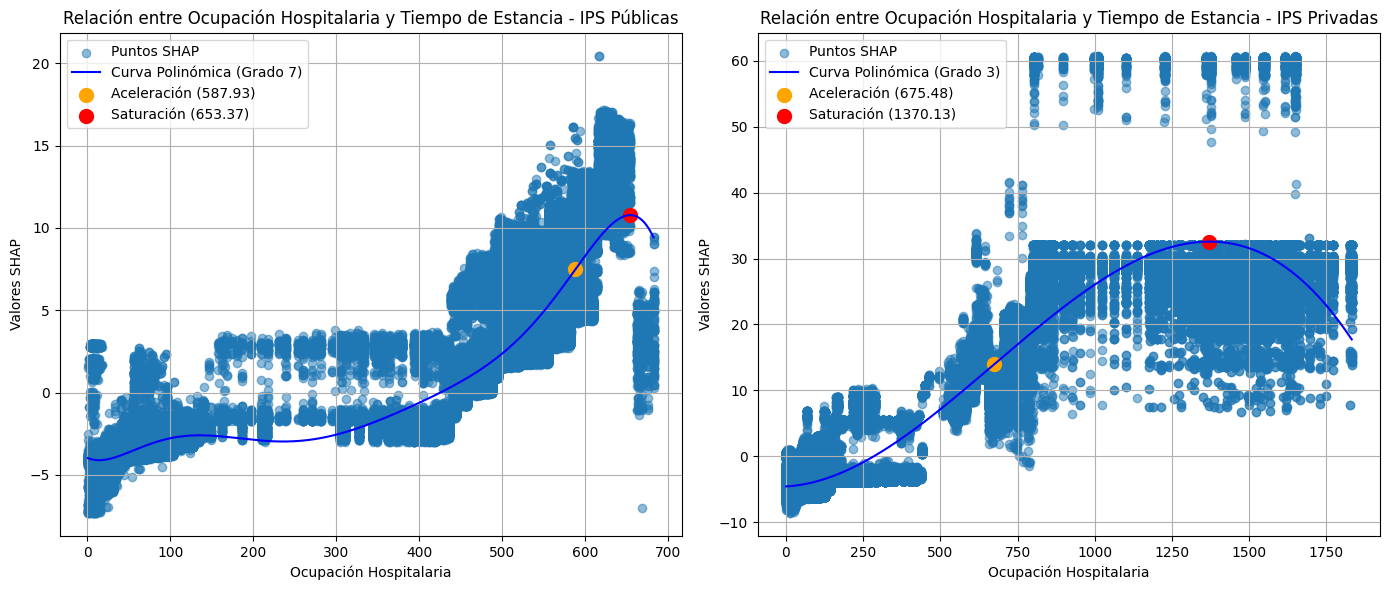

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# Definir las IPS públicas
ips_publicas = [
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SANTA CRUZ VÍCTOR CÁRDENAS JARAMILLO',
    'HOSPITAL GENERAL DE MEDELLIN LUZ CASTRO DE GUTIERREZ, EMPRESA SOCIAL DEL ESTADO - sede HOSPITAL GENERAL DE MEDELLÍN LUZ CASTRO DE GUTIERREZ, EMPRESA SOCIAL DEL ESTADO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DE MANRRIQUE HERMENEGILDO DE FEX',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SAN JAVIER JESÚS PELÁEZ BOTERO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA NUEVO OCCIDENTE',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DE BELEN HECTOR ABAD GOMEZ',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DOCE DE OCTUBRE LUIS CARLOS GALAN SARMIENTO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DE CASTILLA JAIME TOBON ARBELAEZ',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede CENTRO DE SALUD SANTO DOMINGO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SAN CRISTOBAL LEONARDO BETANCUR TABORDA',
    'HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE PRINCIPAL HOSPITAL ALMA MÁTER DE ANTIOQUIA',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SAN ANTONIO DE PRADO DIEGO ECHAVARRIA MISAS',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD DE SALUD MENTAL',
    'ESE HOSPITAL LA MARIA - sede E.S.E. HOSPITAL LA MARIA',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede SEDE ADMINISTRATIVA EDIFICIO SACATIN'
]

# Separar datos en IPS públicas y privadas
X_publicas = X[X['NombrePrestadorSede'].isin(ips_publicas)]
X_privadas = X[~X['NombrePrestadorSede'].isin(ips_publicas)]

# Función para graficar SHAP values ajustando una curva polinómica y calcular aceleración y saturación dinámicamente
def graficar_shap_hospital_occupancy(X_sample, titulo):
    # Calcular los SHAP values para el conjunto de datos
    shap_values_sample = explainer.shap_values(X_sample)

    # Extraer valores de Hospitaloccupancy y sus correspondientes valores SHAP
    hospital_occupancy_values = X_sample['Hospitaloccupancy'].values
    shap_hospital_occupancy_values = shap_values_sample[:, X_sample.columns.get_loc('Hospitaloccupancy')]

    # Ordenar los valores para un análisis más preciso
    sorted_indices = np.argsort(hospital_occupancy_values)
    hospital_occupancy_values_sorted = hospital_occupancy_values[sorted_indices]
    shap_hospital_occupancy_values_sorted = shap_hospital_occupancy_values[sorted_indices]

    # Iterar sobre grados de polinomio para encontrar el primer grado que cumpla los criterios
    grado_optimo = None
    acceleration_point = None
    saturation_point = None

    for grado in range(1, 11):  # Intentar grados del 1 al 10
        # Ajustar una regresión polinómica
        p = Polynomial.fit(hospital_occupancy_values_sorted, shap_hospital_occupancy_values_sorted, deg=grado)

        # Derivar el polinomio ajustado
        polynomial_derivative1 = p.deriv(1)  # Primera derivada

        # Crear un rango denso para evaluar las derivadas
        x_range = np.linspace(hospital_occupancy_values_sorted.min(), hospital_occupancy_values_sorted.max(), num=1000)
        derivative1_values = polynomial_derivative1(x_range)

        # Detectar el punto de máxima aceleración (máximo de la primera derivada)
        acceleration_index = np.argmax(derivative1_values)
        acceleration_point = x_range[acceleration_index]

        # Detectar el punto de saturación considerando la pendiente y el valor SHAP
        x_range_after_acceleration = x_range[acceleration_index + 1:]
        derivative1_values_after_acceleration = derivative1_values[acceleration_index + 1:]
        shap_values_after_acceleration = p(x_range_after_acceleration)

        # Encontrar índices donde la derivada cambia de positiva a negativa
        sign_changes = np.where(np.diff(np.sign(derivative1_values_after_acceleration)) < 0)[0]

        if len(sign_changes) > 0:
            # Considerar todos los puntos donde la pendiente es 0 y elegir el de mayor valor SHAP
            possible_saturation_points = x_range_after_acceleration[sign_changes]
            possible_saturation_shap = shap_values_after_acceleration[sign_changes]
            best_saturation_index = np.argmax(possible_saturation_shap)
            saturation_point = possible_saturation_points[best_saturation_index]

            # Verificar que el punto de saturación es mayor al punto de aceleración
            if saturation_point > acceleration_point:
                grado_optimo = grado
                break

    # Crear el gráfico de dependencia
    plt.scatter(hospital_occupancy_values, shap_hospital_occupancy_values, alpha=0.5, label='Puntos SHAP')
    plt.plot(x_range, p(x_range), color='blue', label=f'Curva Polinómica (Grado {grado_optimo})')
    if acceleration_point:
        plt.scatter(acceleration_point, p(acceleration_point), color='orange', label=f'Aceleración ({acceleration_point:.2f})', s=100, marker='o')
    if saturation_point:
        plt.scatter(saturation_point, p(saturation_point), color='red', label=f'Saturación ({saturation_point:.2f})', s=100, marker='o')
    plt.legend()
    plt.title(titulo)
    plt.xlabel('Ocupación Hospitalaria')
    plt.ylabel('Valores SHAP')
    plt.grid(True)

    # Imprimir los puntos
    print(f"{titulo}")
    print(f"  Grado óptimo: {grado_optimo}")
    print(f"  Punto de aceleración: {acceleration_point:.2f}")
    print(f"  Punto de saturación: {saturation_point:.2f}")
    print()


# Graficar para IPS públicas
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
graficar_shap_hospital_occupancy(X_publicas, 'Relación entre Ocupación Hospitalaria y Tiempo de Estancia - IPS Públicas')

# Graficar para IPS privadas
plt.subplot(1, 2, 2)
graficar_shap_hospital_occupancy(X_privadas, 'Relación entre Ocupación Hospitalaria y Tiempo de Estancia - IPS Privadas')

plt.tight_layout()
plt.show()

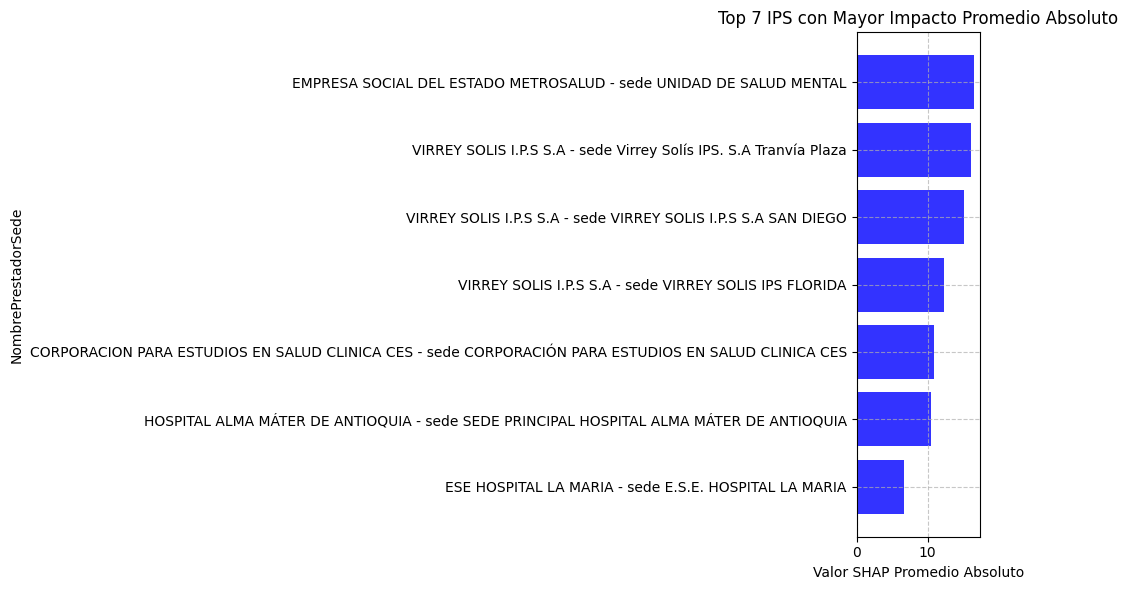

Top 7 IPS con mayor impacto promedio absoluto de enfermedades:
                                 NombrePrestadorSede  \
0  EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UN...   
1  VIRREY SOLIS I.P.S S.A - sede Virrey Solís IPS...   
2  VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS I.P...   
3  VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS IPS...   
4  CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES...   
5  HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE P...   
6  ESE HOSPITAL LA MARIA - sede E.S.E. HOSPITAL L...   

   Valor SHAP Promedio Absoluto  
0                     16.548947  
1                     16.084852  
2                     15.089193  
3                     12.316852  
4                     10.952658  
5                     10.433715  
6                      6.633915  


In [10]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from catboost import Pool
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)

# Lista completa de características
all_features = [
    'NombrePrestadorSede', 
    'DescripcionDiagnosticoPrincipal', 
    'DescripcionDiagnosticoRelacionado_uno', 
    'DescripcionDiagnosticoRelacionado_dos', 
    'Hospitaloccupancy'
]

# Tomar una muestra de los datos con todas las características
X_sample = X[all_features].sample(n=int(len(X)), random_state=42)

# Características categóricas
categorical_columns = [
    'NombrePrestadorSede',
    'DescripcionDiagnosticoPrincipal', 
    'DescripcionDiagnosticoRelacionado_uno', 
    'DescripcionDiagnosticoRelacionado_dos'
]

# Convertir características categóricas a string y manejar NaN
for col in categorical_columns:
    X_sample[col] = X_sample[col].astype(str).fillna('Missing')

# Características numéricas
numerical_columns = ['Hospitaloccupancy']

# Convertir características numéricas a numérico y manejar NaN
for col in numerical_columns:
    X_sample[col] = pd.to_numeric(X_sample[col], errors='coerce').fillna(0)

# Obtener los índices de las características categóricas
cat_features_indices = [X_sample.columns.get_loc(col) for col in categorical_columns]

# Crear el Pool con todas las características
pool = Pool(
    data=X_sample,
    cat_features=cat_features_indices
)

# Calcular los valores SHAP
shap_values = catboost_model.get_feature_importance(
    data=pool,
    type='ShapValues'
)

# Excluir la última columna (expected value)
shap_values = shap_values[:, :-1]

# Crear el DataFrame de SHAP Values
shap_df = pd.DataFrame(shap_values, columns=X_sample.columns)

# Añadir la columna 'NombrePrestadorSede' original
shap_df['NombrePrestadorSede_original'] = X_sample['NombrePrestadorSede'].values

# Calcular el SHAP promedio por institución (NombrePrestadorSede)
shap_promedios_prestador = shap_df.groupby('NombrePrestadorSede_original').mean()

# Calcular el impacto promedio absoluto y obtener las 7 instituciones con mayor impacto
shap_promedios_abs = shap_promedios_prestador.abs().mean(axis=1)
top_prestadores_shap = shap_promedios_abs.nlargest(7)

# Convertir a DataFrame para facilitar el gráfico
top_prestadores_shap_df = top_prestadores_shap.reset_index()
top_prestadores_shap_df.columns = ['NombrePrestadorSede', 'Valor SHAP Promedio Absoluto']

# Ordenar de mayor a menor (descendente)
top_prestadores_shap_df = top_prestadores_shap_df.sort_values(by='Valor SHAP Promedio Absoluto', ascending=False)

# Invertir el orden en el gráfico para que el mayor valor esté arriba
plt.figure(figsize=(10, 6))
plt.barh(top_prestadores_shap_df['NombrePrestadorSede'], top_prestadores_shap_df['Valor SHAP Promedio Absoluto'], color='blue', alpha=0.8)
plt.gca().invert_yaxis()  # Invertir el eje Y para que el valor más alto esté arriba
plt.title('Top 7 IPS con Mayor Impacto Promedio Absoluto')
plt.xlabel('Valor SHAP Promedio Absoluto')
plt.ylabel('NombrePrestadorSede')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de las 7 IPS con mayor impacto
print("Top 7 IPS con mayor impacto promedio absoluto de enfermedades:")
print(top_prestadores_shap_df)


# Hacer el grafico de que como afectan las IPS publicas y las privadas. 





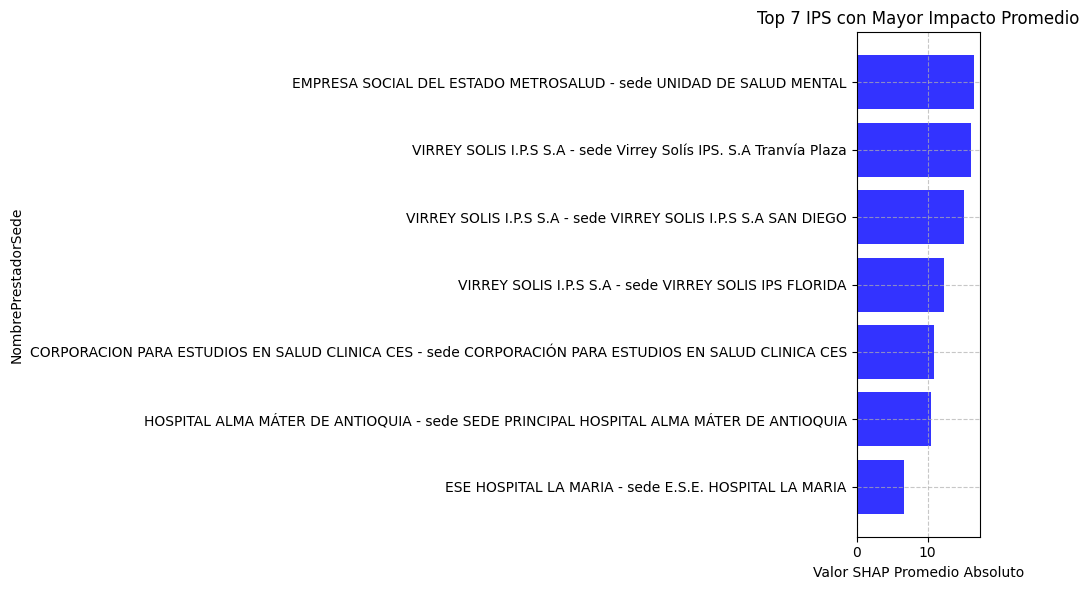

Top 7 IPS con mayor impacto promedio absoluto de enfermedades:
                                 NombrePrestadorSede  \
0  EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UN...   
1  VIRREY SOLIS I.P.S S.A - sede Virrey Solís IPS...   
2  VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS I.P...   
3  VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS IPS...   
4  CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES...   
5  HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE P...   
6  ESE HOSPITAL LA MARIA - sede E.S.E. HOSPITAL L...   

   Valor SHAP Promedio Absoluto  
0                     16.548947  
1                     16.084852  
2                     15.089193  
3                     12.316852  
4                     10.952658  
5                     10.433715  
6                      6.633915  


In [20]:
# Invertir el orden en el gráfico para que el mayor valor esté arriba
plt.figure(figsize=(10, 6))
plt.barh(top_prestadores_shap_df['NombrePrestadorSede'], top_prestadores_shap_df['Valor SHAP Promedio Absoluto'], color='blue', alpha=0.8)
plt.gca().invert_yaxis()  # Invertir el eje Y para que el valor más alto esté arriba
plt.title('Top 7 IPS con Mayor Impacto Promedio')
plt.xlabel('Valor SHAP Promedio Absoluto')
plt.ylabel('NombrePrestadorSede')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de las 7 IPS con mayor impacto
print("Top 7 IPS con mayor impacto promedio absoluto de enfermedades:")
print(top_prestadores_shap_df)

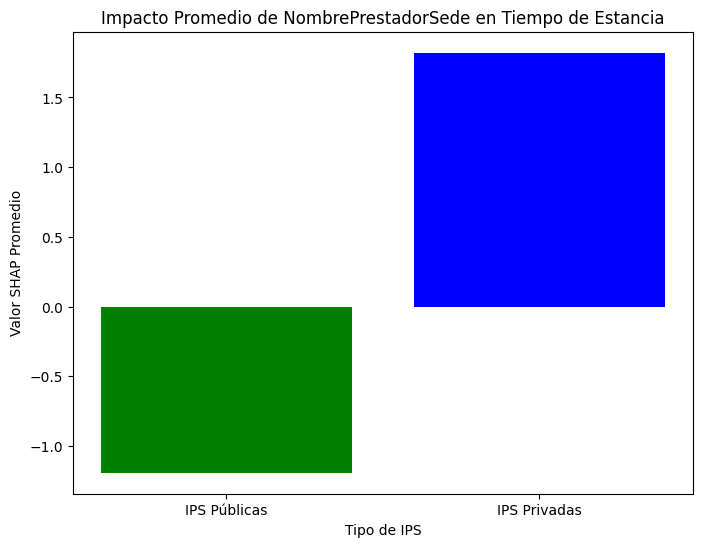

Impacto promedio SHAP de NombrePrestadorSede:
IPS Públicas: -1.19
IPS Privadas: 1.82


In [12]:
import shap
import numpy as np
import matplotlib.pyplot as plt
X_combined = X.copy()
# Definir las IPS públicas

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)

ips_publicas = [
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SANTA CRUZ VÍCTOR CÁRDENAS JARAMILLO',
    'HOSPITAL GENERAL DE MEDELLIN LUZ CASTRO DE GUTIERREZ, EMPRESA SOCIAL DEL ESTADO - sede HOSPITAL GENERAL DE MEDELLÍN LUZ CASTRO DE GUTIERREZ, EMPRESA SOCIAL DEL ESTADO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DE MANRRIQUE HERMENEGILDO DE FEX',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SAN JAVIER JESÚS PELÁEZ BOTERO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA NUEVO OCCIDENTE',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DE BELEN HECTOR ABAD GOMEZ',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DOCE DE OCTUBRE LUIS CARLOS GALAN SARMIENTO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA DE CASTILLA JAIME TOBON ARBELAEZ',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede CENTRO DE SALUD SANTO DOMINGO',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SAN CRISTOBAL LEONARDO BETANCUR TABORDA',
    'HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE PRINCIPAL HOSPITAL ALMA MÁTER DE ANTIOQUIA',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD HOSPITALARIA SAN ANTONIO DE PRADO DIEGO ECHAVARRIA MISAS',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD DE SALUD MENTAL',
    'ESE HOSPITAL LA MARIA - sede E.S.E. HOSPITAL LA MARIA',
    'EMPRESA SOCIAL DEL ESTADO METROSALUD - sede SEDE ADMINISTRATIVA EDIFICIO SACATIN'
]

# Filtrar los datos en dos grupos: IPS públicas y privadas
X_publicas = X[X['NombrePrestadorSede'].isin(ips_publicas)]
X_privadas = X[~X['NombrePrestadorSede'].isin(ips_publicas)]

# Calcular los SHAP values para ambos grupos
shap_values_publicas = explainer.shap_values(X_publicas)
shap_values_privadas = explainer.shap_values(X_privadas)

# Extraer los SHAP values de la columna 'NombrePrestadorSede' para ambos grupos
shap_nombre_prestador_publicas = shap_values_publicas[:, X.columns.get_loc('NombrePrestadorSede')]
shap_nombre_prestador_privadas = shap_values_privadas[:, X.columns.get_loc('NombrePrestadorSede')]

# Calcular el promedio del impacto SHAP para 'NombrePrestadorSede' en cada grupo
promedio_shap_publicas = np.mean(shap_nombre_prestador_publicas)
promedio_shap_privadas = np.mean(shap_nombre_prestador_privadas)

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(['IPS Públicas', 'IPS Privadas'], [promedio_shap_publicas, promedio_shap_privadas], color=['green', 'blue'])
plt.title('Impacto Promedio de NombrePrestadorSede en Tiempo de Estancia')
plt.ylabel('Valor SHAP Promedio')
plt.xlabel('Tipo de IPS')
plt.show()

# Imprimir los valores promedio de los impactos SHAP
print("Impacto promedio SHAP de NombrePrestadorSede:")
print(f"IPS Públicas: {promedio_shap_publicas:.2f}")
print(f"IPS Privadas: {promedio_shap_privadas:.2f}")



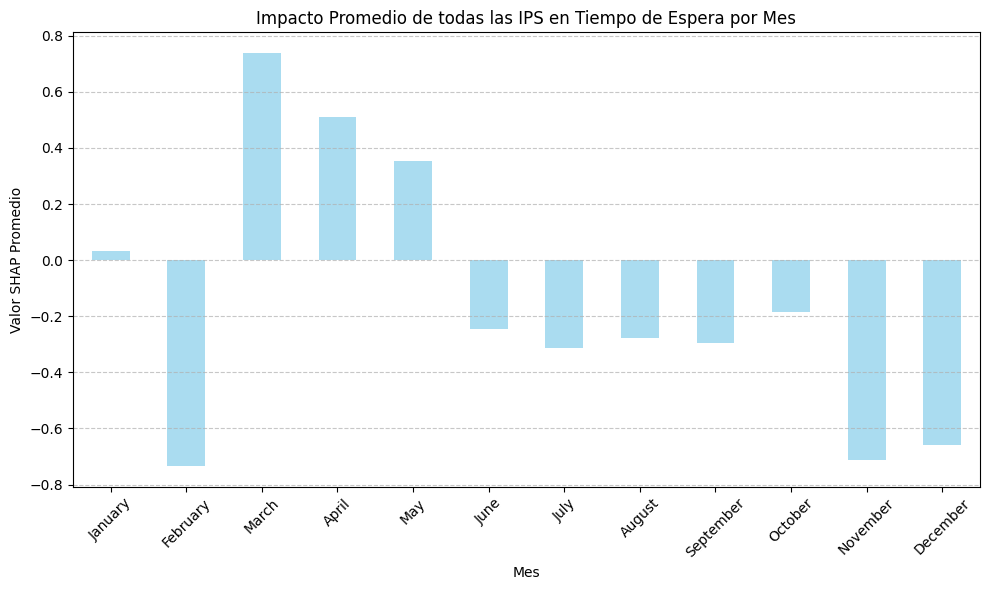

Impacto promedio de todas las IPS en tiempo de espera por mes:
Mes
January      0.033417
February    -0.733503
March        0.738570
April        0.509992
May          0.354674
June        -0.244447
July        -0.314154
August      -0.276226
September   -0.293778
October     -0.183707
November    -0.712547
December    -0.659764
Name: Promedio_SHAP, dtype: float64


In [13]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información del mes y IPS
X_dos = df.loc[X_sample.index, ['FechaIngreso', 'NombrePrestadorSede']].copy()

# Asegurarse de que 'FechaIngreso' esté en formato datetime y extraer el mes
X_dos['FechaIngreso'] = pd.to_datetime(X_dos['FechaIngreso'], errors='coerce')
X_dos['Mes'] = X_dos['FechaIngreso'].dt.month_name()

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los valores SHAP para todas las columnas
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)
shap_df_sample['Mes'] = X_dos['Mes'].values  # Añadir la columna del mes
shap_df_sample['NombrePrestadorSede'] = X_dos['NombrePrestadorSede'].values  # Añadir la columna de IPS

# Calcular el promedio de los valores SHAP en cada fila solo en las columnas numéricas
shap_numeric_cols = shap_df_sample.select_dtypes(include=[np.number]).columns
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_numeric_cols].mean(axis=1)

# Agrupar por mes para obtener el promedio general de todas las IPS en cada mes
impacto_promedio_mensual_ips = shap_df_sample.groupby('Mes')['Promedio_SHAP'].mean()

# Ordenar los meses en orden cronológico
meses_orden = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
impacto_promedio_mensual_ips = impacto_promedio_mensual_ips.reindex(meses_orden)

# Graficar el impacto promedio de todas las IPS en tiempo de espera por mes
plt.figure(figsize=(10, 6))
impacto_promedio_mensual_ips.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Impacto Promedio de todas las IPS en Tiempo de Espera por Mes')
plt.xlabel('Mes')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de todas las IPS por mes
print("Impacto promedio de todas las IPS en tiempo de espera por mes:")
print(impacto_promedio_mensual_ips)








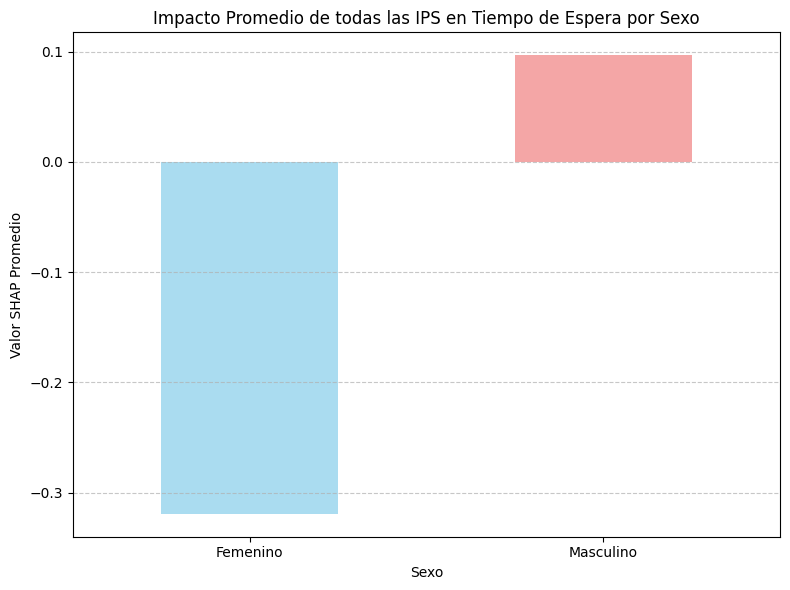

Impacto promedio de todas las IPS en tiempo de espera por sexo:
Sexo
Femenino    -0.319229
Masculino    0.096776
Name: Promedio_SHAP, dtype: float64


In [23]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información del sexo y IPS
X_dos = df.loc[X_sample.index, ['Sexo', 'NombrePrestadorSede']].copy()

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los valores SHAP para todas las columnas
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)
shap_df_sample['Sexo'] = X_dos['Sexo'].values  # Añadir la columna de Sexo
shap_df_sample['NombrePrestadorSede'] = X_dos['NombrePrestadorSede'].values  # Añadir la columna de IPS

# Calcular el promedio de los valores SHAP en cada fila solo en las columnas numéricas
shap_numeric_cols = shap_df_sample.select_dtypes(include=[np.number]).columns
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_numeric_cols].mean(axis=1)

# Agrupar por sexo para obtener el promedio general de todas las IPS en cada grupo de sexo
impacto_promedio_sexo = shap_df_sample.groupby('Sexo')['Promedio_SHAP'].mean()

# Renombrar el índice para una mejor interpretación
impacto_promedio_sexo.index = impacto_promedio_sexo.index.map({'M': 'Masculino', 'F': 'Femenino'})

# Graficar el impacto promedio de todas las IPS en tiempo de espera por sexo
plt.figure(figsize=(8, 6))
impacto_promedio_sexo.plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('Impacto Promedio de todas las IPS en Tiempo de Espera por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Valor SHAP Promedio')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el impacto promedio de todas las IPS por sexo
print("Impacto promedio de todas las IPS en tiempo de espera por sexo:")
print(impacto_promedio_sexo)


In [15]:
import pandas as pd
import shap
import joblib

# Cargar el modelo CatBoost guardado
model_save_path_catboost = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/mejor_modelo_catboost_sin_tipodeusuario_final_final.pkl"
catboost_model = joblib.load(model_save_path_catboost)
X_combined = X.copy()

# Crear una copia de X_combined para muestreo
sample_size = int(len(X_combined))  
X_sample = X_combined.sample(n=sample_size, random_state=42)

# Crear X_dos con las mismas filas e índice que X_sample para obtener información del mes y IPS
X_dos = df.loc[X_sample.index, ['FechaIngreso', 'NombrePrestadorSede']].copy()

# Asegurarse de que 'FechaIngreso' esté en formato datetime y extraer el mes
X_dos['FechaIngreso'] = pd.to_datetime(X_dos['FechaIngreso'], errors='coerce')
X_dos['Mes'] = X_dos['FechaIngreso'].dt.month_name()

# Calcular los valores SHAP para el modelo CatBoost entrenado en el muestreo
explainer = shap.TreeExplainer(catboost_model)
shap_values_sample = explainer.shap_values(X_sample)

# Crear un DataFrame con los valores SHAP y añadir columnas de mes y IPS
shap_df_sample = pd.DataFrame(shap_values_sample, columns=X.columns)
shap_df_sample['Mes'] = X_dos['Mes'].values  # Añadir la columna del mes
shap_df_sample['NombrePrestadorSede'] = X_dos['NombrePrestadorSede'].values  # Añadir la columna de IPS

# Calcular el promedio de los valores SHAP en cada fila solo en las columnas numéricas
shap_numeric_cols = shap_df_sample.select_dtypes(include=[np.number]).columns
shap_df_sample['Promedio_SHAP'] = shap_df_sample[shap_numeric_cols].mean(axis=1)

# Filtrar datos para los meses de marzo y abril
shap_marzo = shap_df_sample[shap_df_sample['Mes'] == 'March']
shap_abril = shap_df_sample[shap_df_sample['Mes'] == 'April']

# Calcular el impacto promedio de cada IPS en marzo
top_ips_marzo = shap_marzo.groupby('NombrePrestadorSede')['Promedio_SHAP'].mean().nlargest(10)

# Calcular el impacto promedio de cada IPS en abril
top_ips_abril = shap_abril.groupby('NombrePrestadorSede')['Promedio_SHAP'].mean().nlargest(10)

# Mostrar resultados
print("Top 10 IPS que más impactan el valor SHAP en Marzo:")
print(top_ips_marzo)

print("\nTop 10 IPS que más impactan el valor SHAP en Abril:")
print(top_ips_abril)


Top 10 IPS que más impactan el valor SHAP en Marzo:
NombrePrestadorSede
VIDA SANA IPS LTDA                                                                                                        11.771153
VIRREY SOLIS I.P.S S.A - sede VIRREY SOLIS I.P.S S.A SAN DIEGO                                                             8.134746
EMPRESA SOCIAL DEL ESTADO METROSALUD - sede UNIDAD DE SALUD MENTAL                                                         6.484262
HOSPITAL ALMA MÁTER DE ANTIOQUIA - sede SEDE PRINCIPAL HOSPITAL ALMA MÁTER DE ANTIOQUIA                                    5.808257
CORPORACION PARA ESTUDIOS EN SALUD CLINICA CES - sede CORPORACIÓN PARA ESTUDIOS EN SALUD CLINICA CES                       0.687289
ENDOGINE IPS S.A.S. - sede Endogine IPS SAS                                                                                0.422155
NUEVA CLINICA SAGRADO CORAZON S.A.S - sede NUEVA CLINICA SAGRADO CORAZON S.A.S                                            -0.162680
CLIN

# LightGBM

In [23]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import make_scorer, mean_absolute_error

# Definir el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', metric='mae', verbosity=-1)

# Definir el conjunto de hiperparámetros para Grid Search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'max_depth': [3, 5, 7],
    'min_data_in_leaf': [50, 100],
    'lambda_l2': [10, 15],
}

# Crear el MAE como métrica de evaluación
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Configurar el Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer, verbose=1)

# Entrenar el Grid Search en los datos
grid_search.fit(X_combined, y)

# Obtener los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"Mejor MAE en validación: {grid_search.best_score_}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros encontrados: {'lambda_l2': 10, 'learning_rate': 0.05, 'max_depth': 7, 'min_data_in_leaf': 100, 'num_leaves': 50}
Mejor MAE en validación: -21.11874989491003


In [38]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import joblib
from itertools import chain, combinations

# Definir parámetros de LightGBM
params_lightgbm = {
    'objective': 'regression',  
    'metric': 'mae',            
    'learning_rate': 0.05,      
    'num_leaves': 50,           
    'max_depth': 7,             
    'lambda_l2': 10,            
    'min_data_in_leaf': 100,     
    'feature_fraction': 0.8,    
    'bagging_fraction': 0.8,    
    'bagging_freq': 5,          
    'verbosity': -1             
}

# Convertir las columnas categóricas
categorical_columns = ['CausaExterna', 'TipoUsuario', 'Sexo', 'ZonaResidencia', 'NombrePrestadorSede', 
                       'nombreEAPB', 'NombreMunicipio', 'DescripcionDiagnosticoPrincipal', 
                       'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 
                       'DescripcionDiagnosticoRelacionado_tres', 'NombreDepto']
X[categorical_columns] = X[categorical_columns].astype('category')

# Entrenar modelo con todas las variables para obtener las importancias
kf = KFold(n_splits=5, shuffle=True, random_state=42)
full_val_mae_scores = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_columns)
    lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=categorical_columns)

    model = lgb.train(params_lightgbm, lgb_train, valid_sets=[lgb_val], num_boost_round=500, 
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    val_preds = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_preds)
    full_val_mae_scores.append(val_mae)

# Obtener la importancia de características del modelo completo
feature_importances = model.feature_importance(importance_type='split')
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Identificar las cinco variables de menor importancia
low_importance_features = feature_importances_df['Feature'].head(5).tolist()
print(f"Cinco variables de menor importancia: {low_importance_features}")

# Generar todas las combinaciones posibles con estas cinco variables
def power_set(variables):
    return chain.from_iterable(combinations(variables, r) for r in range(len(variables)+1))

# Probar todas las combinaciones de estas cinco variables
results = []
for combination in power_set(low_importance_features):
    # Mantener sólo las variables que no están en la combinación
    selected_features = [col for col in X.columns if col not in low_importance_features or col in combination]
    val_mae_scores = []
    
    # Evaluar con K-Fold
    for train_index, val_index in kf.split(X[selected_features]):
        X_train, X_val = X[selected_features].iloc[train_index], X[selected_features].iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=[col for col in categorical_columns if col in selected_features])
        lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=[col for col in categorical_columns if col in selected_features])

        model = lgb.train(params_lightgbm, lgb_train, valid_sets=[lgb_val], num_boost_round=500, 
                          callbacks=[lgb.early_stopping(stopping_rounds=50)])
        
        val_preds = model.predict(X_val)
        val_mae = mean_absolute_error(y_val, val_preds)
        val_mae_scores.append(val_mae)

    mean_val_mae = np.mean(val_mae_scores)
    results.append((combination, mean_val_mae))

# Encontrar la mejor combinación de variables
best_combination, best_mae = min(results, key=lambda x: x[1])
print(f"\nMejor combinación de las variables de baja importancia: {best_combination} - MAE: {best_mae:.4f}")

# Guardar el mejor modelo
model_save_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/lightgbm_reduced_model_mae.pkl"
joblib.dump(model, model_save_path)
print(f"\nMejor modelo guardado en: {model_save_path}")













Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l1: 20.1588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l1: 20.2923
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's l1: 20.088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's l1: 20.3038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[209]	valid_0's l1: 20.2981
Cinco variables de menor importancia: ['NombreDepto', 'ZonaResidencia', 'DescripcionDiagnosticoRelacionado_tres', 'TipoUsuario', 'Sexo']
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l1: 20.1454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's l1: 20.2

# Importancia variables modelo LightGBM

                                   Feature  Importance
7          DescripcionDiagnosticoPrincipal        1178
8    DescripcionDiagnosticoRelacionado_uno        1033
11                       Hospitaloccupancy        1022
4                      NombrePrestadorSede         875
5                               nombreEAPB         685
9    DescripcionDiagnosticoRelacionado_dos         566
2                                     Edad         542
6                          NombreMunicipio         248
0                             CausaExterna          89
3                                     Sexo          49
1                              TipoUsuario          32
10  DescripcionDiagnosticoRelacionado_tres          13


<Figure size 1000x800 with 0 Axes>

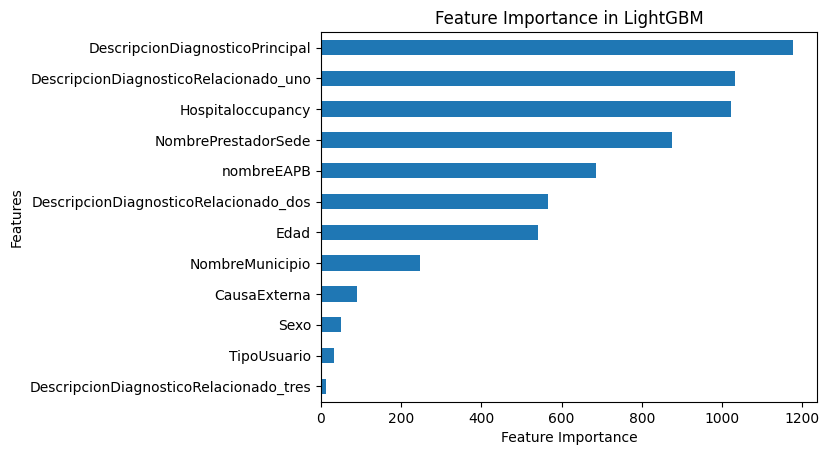

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener la importancia de características del modelo LightGBM
feature_importances = model_lightgbm.feature_importance(importance_type='split')

# Verificar que la longitud de feature_importances coincida con las características de X
if len(feature_importances) == len(X.columns):
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })
else:
    # Obtener solo las características utilizadas por LightGBM
    features_used = model_lightgbm.feature_name()
    feature_importances_df = pd.DataFrame({
        'Feature': features_used,
        'Importance': feature_importances
    })

# Ordenar por importancia y mostrar
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

# Graficar la importancia de características
plt.figure(figsize=(10, 8))
feature_importances_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in LightGBM")
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes aparezcan arriba
plt.show()


In [65]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import joblib

# Seleccionar las mejores variables
selected_features = [
    'DescripcionDiagnosticoPrincipal', 'DescripcionDiagnosticoRelacionado_uno', 'Hospitaloccupancy',
    'NombrePrestadorSede', 'nombreEAPB', 'DescripcionDiagnosticoRelacionado_dos',
    'Edad', 'NombreMunicipio', 'CausaExterna', 'Sexo', 'TipoUsuario', 'DescripcionDiagnosticoRelacionado_tres'
]

# Filtrar el DataFrame X para solo incluir las mejores variables
X_selected = X[selected_features]

# Definir las columnas categóricas relevantes
categorical_columns = ['CausaExterna', 'TipoUsuario', 'NombrePrestadorSede', 
                       'nombreEAPB', 'NombreMunicipio', 'DescripcionDiagnosticoPrincipal', 
                       'DescripcionDiagnosticoRelacionado_uno', 'DescripcionDiagnosticoRelacionado_dos', 
                       'DescripcionDiagnosticoRelacionado_tres', 'Sexo']

# Convertir las variables categóricas a tipo 'category'
for col in categorical_columns:
    if col in X_selected.columns:
        X_selected[col] = X_selected[col].astype('category')

# Definir los hiperparámetros para LightGBM
params_lightgbm = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 50,
    'max_depth': 7,
    'lambda_l2': 10,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

# Crear una instancia de KFold para validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mae_scores = []
val_mae_scores = []

# Validación cruzada
for fold, (train_index, val_index) in enumerate(kf.split(X_selected), 1):
    X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Crear los datasets para LightGBM
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_columns)
    lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=categorical_columns)

    # Entrenar el modelo
    model_lightgbm = lgb.train(params_lightgbm, lgb_train, valid_sets=[lgb_val], 
                               num_boost_round=500, callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    # Evaluar el modelo
    train_preds = model_lightgbm.predict(X_train)
    val_preds = model_lightgbm.predict(X_val)
    
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)

    train_mae_scores.append(train_mae)
    val_mae_scores.append(val_mae)
    
    print(f"Fold {fold} - MAE en Entrenamiento: {train_mae:.4f}, MAE en Validación: {val_mae:.4f}")

# Imprimir los resultados promedios de los folds
print(f"\nMAE Promedio en Entrenamiento: {np.mean(train_mae_scores):.4f}")
print(f"MAE Promedio en Validación: {np.mean(val_mae_scores):.4f}")



C:\Users\jpcan\AppData\Local\Temp\ipykernel_46960\852670612.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected[col] = X_selected[col].astype('category')
C:\Users\jpcan\AppData\Local\Temp\ipykernel_46960\852670612.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected[col] = X_selected[col].astype('category')
C:\Users\jpcan\AppData\Local\Temp\ipykernel_46960\852670612.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l1: 20.16
Fold 1 - MAE en Entrenamiento: 19.7852, MAE en Validación: 20.1600
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid_0's l1: 20.3089
Fold 2 - MAE en Entrenamiento: 19.7640, MAE en Validación: 20.3089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's l1: 20.0869
Fold 3 - MAE en Entrenamiento: 19.7228, MAE en Validación: 20.0869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's l1: 20.2802
Fold 4 - MAE en Entrenamiento: 19.8004, MAE en Validación: 20.2802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's l1: 20.3301
Fold 5 - MAE en Entrenamiento: 19.7557, MAE en Validación: 20.3301

MAE Promedio en Entrenamiento: 19.7656
MAE Pro

# Red Neuronal con Capas de Embeddings

In [4]:
import tensorflow as tf 
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

# Convertir las variables categóricas a índices para embeddings
encoders = {}
X_encoded = X.copy()

for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    encoders[col] = le

# Crear capas de embeddings para variables categóricas con regularización L2
def create_embedding_layers(categorical_columns, X_encoded):
    input_layers = []
    embedding_layers = []
    
    for col in categorical_columns:
        input_layer = Input(shape=(1,))
        input_layers.append(input_layer)
        
        # Crear capa de embeddings para cada variable categórica con regularización L2
        num_categories = X_encoded[col].nunique()
        embedding_size = min(50, (num_categories + 1) // 2)  # Tamaño del embedding
        embedding_layer = Embedding(input_dim=num_categories + 1, output_dim=embedding_size, 
                                    embeddings_regularizer=l2(1e-4))(input_layer)
        embedding_layer = Flatten()(embedding_layer)
        embedding_layers.append(embedding_layer)
    
    concatenated = Concatenate()(embedding_layers)
    return input_layers, concatenated

# Crear una función que construya y compile el modelo con dropout y regularización L2
def create_model(categorical_columns, X_encoded):
    input_layers, concatenated = create_embedding_layers(categorical_columns, X_encoded)
    
    # Añadir capas densas con regularización L2 y dropout
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(concatenated)
    x = Dropout(0.3)(x)  # Dropout con tasa de 30%
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    output = Dense(1)(x)
    
    # Construir el modelo
    model = Model(inputs=input_layers, outputs=output)
    model.compile(optimizer='adam', loss='mae')  # MAE como métrica de pérdida
    
    return model, input_layers

# Crear una instancia de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae_train = []
cv_mae_val = []
best_val_mae = float('inf')
best_model = None

# Validación cruzada de 5 folds
for fold, (train_index, val_index) in enumerate(kf.split(X_encoded), 1):
    X_train_fold = X_encoded.iloc[train_index]
    X_val_fold = X_encoded.iloc[val_index]
    y_train_fold = y.iloc[train_index]
    y_val_fold = y.iloc[val_index]
    
    model, input_layers = create_model(categorical_columns, X_encoded)
    
    # Convertir los datos en listas para el modelo
    X_train_list = [X_train_fold[col].values for col in categorical_columns]
    X_val_list = [X_val_fold[col].values for col in categorical_columns]
    
    # Implementar early stopping para evitar el sobreajuste
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Entrenar el modelo
    model.fit(X_train_list, y_train_fold, validation_data=(X_val_list, y_val_fold), 
              epochs=50, batch_size=64, verbose=0, callbacks=[early_stopping])
    
    # Evaluar el modelo en el conjunto de entrenamiento
    train_mae = model.evaluate(X_train_list, y_train_fold, verbose=0)
    cv_mae_train.append(train_mae)
    
    # Evaluar el modelo en el conjunto de validación
    val_mae = model.evaluate(X_val_list, y_val_fold, verbose=0)
    cv_mae_val.append(val_mae)
    
    # Imprimir el MAE de cada fold
    print(f"Fold {fold}: MAE en Entrenamiento: {train_mae:.4f}, MAE en Validación: {val_mae:.4f}")
    
    # Guardar el modelo con el menor MAE en validación
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model

# Promedio de MAE para validación y entrenamiento
avg_mae_train = np.mean(cv_mae_train)
avg_mae_val = np.mean(cv_mae_val)

print(f"\nMAE promedio en el conjunto de entrenamiento: {avg_mae_train:.4f}")
print(f"MAE promedio en el conjunto de validación: {avg_mae_val:.4f}")

# Guardar el mejor modelo
model_file_path = "C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/best_nn_model_mae.h5"
best_model.save(model_file_path)
print(f"Mejor modelo guardado en: {model_file_path}")






Fold 1: MAE en Entrenamiento: 17.2609, MAE en Validación: 17.2186
Fold 2: MAE en Entrenamiento: 16.9904, MAE en Validación: 17.3395
Fold 3: MAE en Entrenamiento: 17.0884, MAE en Validación: 17.1284
Fold 4: MAE en Entrenamiento: 17.1362, MAE en Validación: 17.1044


Fold 5: MAE en Entrenamiento: 17.0746, MAE en Validación: 17.3533

MAE promedio en el conjunto de entrenamiento: 17.1101
MAE promedio en el conjunto de validación: 17.2288
Mejor modelo guardado en: C:/Users/jpcan/OneDrive/Documentos/Andes Universidad/Proyecto de grado 1/Modelos/best_nn_model_mae.h5
